# Extractor Pipeline Debug Notebook

This notebook compares the original working watershed algorithm with the new ExtractorPipeline implementation to identify and fix differences.

In [55]:
# Setup and Data Loading
from pathlib import Path
import tifffile
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.stats import entropy as scipy_entropy
from scipy.ndimage import binary_fill_holes, label as ndi_label, distance_transform_edt
from skimage.segmentation import expand_labels, watershed, find_boundaries
from skimage import morphology
import sys

# Project paths
notebook = Path(r"C:\Users\admin\Documents\Pierre lab\projects\Colustrum-ABX\lysozyme stain quantification\code\component development")
project_root = notebook.parent.parent
print(f"Project root: {project_root}")

# Add src to path to import our pipeline
src_path = project_root / "code" / "src"
sys.path.insert(0, str(src_path))
print(f"Added to path: {src_path}")

# Test that we can import our pipeline
try:
    from processing.extractor_pipeline import ExtractorPipeline
    from utils.file_utils import load_as_gray, build_rgb, remove_rectangles
    from utils.image_utils import minmax01
    print("✓ Successfully imported pipeline components")
except ImportError as e:
    print(f"✗ Import failed: {e}")

Project root: C:\Users\admin\Documents\Pierre lab\projects\Colustrum-ABX\lysozyme stain quantification
Added to path: C:\Users\admin\Documents\Pierre lab\projects\Colustrum-ABX\lysozyme stain quantification\code\src
✓ Successfully imported pipeline components


In [56]:
# Load test image and prepare helper functions
images_root = project_root / 'lysozyme images'
test_red_path = images_root / "Jej LYZ" / "G2" / "G2EL - 1_RFP.tif"
test_blue_path = images_root / "Jej LYZ" / "G2" / "G2EL - 1_DAPI.tif"

print(f"Red path exists: {test_red_path.exists()}")
print(f"Blue path exists: {test_blue_path.exists()}")

# Original notebook helper functions
def load_as_gray_orig(p: Path):
    """Original notebook version"""
    arr = tifffile.imread(p)
    if arr.ndim == 3:
        if arr.shape[0] <= 4 and arr.shape[0] < arr.shape[-1]:
            arr = np.moveaxis(arr, 0, -1)
        if arr.shape[-1] in (3,4):
            arr = cv2.cvtColor(arr[..., :3].astype(np.uint8), cv2.COLOR_RGB2GRAY)
        else:
            arr = arr[...,0]
    return arr.astype(np.float32)

def build_rgb_orig(red_gray, blue_gray):
    """Original notebook version"""
    def to_u8(x):
        if x.dtype != np.uint8:
            lo, hi = np.nanmin(x), np.nanmax(x)
            if hi > lo:
                x = (x - lo)/(hi-lo)*255.0
            else:
                x = np.zeros_like(x)
            return x.astype(np.uint8)
        return x
    r8 = to_u8(red_gray)
    b8 = to_u8(blue_gray)
    zeros = np.zeros_like(r8)
    return np.stack([r8, zeros, b8], axis=-1)

def minmax01_orig(x, eps=1e-12):
    """Original notebook version"""
    x = x.astype(float, copy=False)
    lo = np.min(x)
    hi = np.max(x)
    return (x - lo) / max(hi - lo, eps)

Red path exists: True
Blue path exists: True


In [57]:
# Load and preprocess images - Compare methods
print("=" * 60)
print("COMPARING IMAGE LOADING AND PREPROCESSING")
print("=" * 60)

# Load with original method
r_orig = load_as_gray_orig(test_red_path)
b_orig = load_as_gray_orig(test_blue_path)
print(f"Original method - Red: {r_orig.shape}, range [{r_orig.min():.2f}, {r_orig.max():.2f}]")
print(f"Original method - Blue: {b_orig.shape}, range [{b_orig.min():.2f}, {b_orig.max():.2f}]")

# Load with pipeline method
r_pipeline = load_as_gray(test_red_path)
b_pipeline = load_as_gray(test_blue_path)
print(f"Pipeline method - Red: {r_pipeline.shape}, range [{r_pipeline.min():.2f}, {r_pipeline.max():.2f}]")
print(f"Pipeline method - Blue: {b_pipeline.shape}, range [{b_pipeline.min():.2f}, {b_pipeline.max():.2f}]")

# Check if they're identical
print(f"Red images identical: {np.allclose(r_orig, r_pipeline)}")
print(f"Blue images identical: {np.allclose(b_orig, b_pipeline)}")

# Build RGB with both methods
disp_orig = build_rgb_orig(r_orig, b_orig)
disp_pipeline = build_rgb(r_pipeline, b_pipeline)

print(f"Original RGB: {disp_orig.shape}, dtype {disp_orig.dtype}")
print(f"Pipeline RGB: {disp_pipeline.shape}, dtype {disp_pipeline.dtype}")
print(f"RGB displays identical: {np.allclose(disp_orig, disp_pipeline)}")

# Use original method for the rest (to match notebook exactly)
r = r_orig
b = b_orig
disp = disp_orig

COMPARING IMAGE LOADING AND PREPROCESSING
Original method - Red: (960, 1280), range [3.00, 76.00]
Original method - Blue: (960, 1280), range [3.00, 33.00]
Pipeline method - Red: (960, 1280), range [3.00, 76.00]
Pipeline method - Blue: (960, 1280), range [3.00, 33.00]
Red images identical: True
Blue images identical: True
Original RGB: (960, 1280, 3), dtype uint8
Pipeline RGB: (960, 1280, 3), dtype uint8
RGB displays identical: True


In [58]:
# ORIGINAL NOTEBOOK ALGORITHM (STEP BY STEP)
print("=" * 60)
print("RUNNING ORIGINAL NOTEBOOK ALGORITHM")
print("=" * 60)

# Apply remove_rectangles
try:
    disp = remove_rectangles(disp)
    print("✓ Rectangle removal applied")
except Exception as e:
    print(f"⚠ Rectangle removal failed: {e}")

# Extract red and blue channels from display
red_orig = disp[...,0].astype(np.float32)
blue_orig = disp[...,2].astype(np.float32)
print(f"Red from display: range [{red_orig.min():.2f}, {red_orig.max():.2f}]")
print(f"Blue from display: range [{blue_orig.min():.2f}, {blue_orig.max():.2f}]")

# Morphological operations
mask_r_dilation_orig = np.maximum(blue_orig, red_orig)
mask_r_erosion_orig = np.minimum(blue_orig, red_orig)
print(f"Dilation mask: range [{mask_r_dilation_orig.min():.2f}, {mask_r_dilation_orig.max():.2f}]")
print(f"Erosion mask: range [{mask_r_erosion_orig.min():.2f}, {mask_r_erosion_orig.max():.2f}]")

# diff_r
diff_r_orig = red_orig > mask_r_erosion_orig
print(f"diff_r raw: {np.sum(diff_r_orig)} pixels")

diff_r_orig = morphology.binary_erosion(diff_r_orig, footprint=np.ones((3,3)))
diff_r_orig = morphology.remove_small_objects(diff_r_orig, min_size=100)
print(f"diff_r final: {np.sum(diff_r_orig)} pixels")

# Secondary mask
abs_diff_orig = np.abs(mask_r_dilation_orig - red_orig)
mask_gt_red_orig = abs_diff_orig > red_orig
print(f"abs_diff range: [{abs_diff_orig.min():.2f}, {abs_diff_orig.max():.2f}]")
print(f"mask_gt_red: {np.sum(mask_gt_red_orig)} pixels")

# Erosion
erosion_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (6,6))
mask_u8 = (mask_gt_red_orig.astype(np.uint8)*255)
mask_eroded_u8 = cv2.erode(mask_u8, erosion_kernel, iterations=2)
mask_gt_red_eroded_orig = mask_eroded_u8.astype(bool)
print(f"mask_gt_red_eroded: {np.sum(mask_gt_red_eroded_orig)} pixels")

# Combined labels
combined_labels_orig = np.zeros_like(diff_r_orig, dtype=int)
combined_labels_orig[mask_gt_red_eroded_orig] = 2
combined_labels_orig[diff_r_orig] = 1
unique_combined = np.unique(combined_labels_orig)
counts = [(label, np.sum(combined_labels_orig == label)) for label in unique_combined]
print(f"Combined labels: {counts}")

RUNNING ORIGINAL NOTEBOOK ALGORITHM
✓ Rectangle removal applied
Red from display: range [0.00, 255.00]
Blue from display: range [0.00, 255.00]
Dilation mask: range [0.00, 255.00]
Erosion mask: range [0.00, 170.00]


diff_r raw: 27276 pixels
diff_r final: 5434 pixels
abs_diff range: [0.00, 186.00]
diff_r final: 5434 pixels
abs_diff range: [0.00, 186.00]
mask_gt_red: 1077348 pixels
mask_gt_red_eroded: 487669 pixels
Combined labels: [(np.int64(0), np.int64(735697)), (np.int64(1), np.int64(5434)), (np.int64(2), np.int64(487669))]
mask_gt_red: 1077348 pixels
mask_gt_red_eroded: 487669 pixels
Combined labels: [(np.int64(0), np.int64(735697)), (np.int64(1), np.int64(5434)), (np.int64(2), np.int64(487669))]


In [59]:
# Complete original watershed algorithm
print("=" * 60)
print("COMPLETING ORIGINAL WATERSHED ALGORITHM")
print("=" * 60)

# Expand labels
expanded_labels_orig = expand_labels(combined_labels_orig, distance=100)
unique_expanded = np.unique(expanded_labels_orig)
print(f"Expanded labels: {len(unique_expanded)} unique values")
if len(unique_expanded) <= 20:
    print(f"Expanded values: {unique_expanded}")

# Markers from diff_r
labeled_diff_r_orig, _ = ndi_label(diff_r_orig != 0)
print(f"labeled_diff_r: max {labeled_diff_r_orig.max()} regions")

# Reworked markers
reworked_orig = np.zeros_like(expanded_labels_orig, dtype=np.int32)
reworked_orig[expanded_labels_orig == 2] = 1
mask_copy = (expanded_labels_orig != 2) & (labeled_diff_r_orig != 0)
reworked_orig[mask_copy] = labeled_diff_r_orig[mask_copy] + 1
unique_reworked = np.unique(reworked_orig)
print(f"Reworked markers: {len(unique_reworked)} unique, max: {reworked_orig.max()}")

# Watershed mask
mask_ws_orig = expanded_labels_orig > 0
print(f"Watershed mask: {np.sum(mask_ws_orig)} pixels")

# Elevation
elevation_orig = (
    minmax01_orig(distance_transform_edt(combined_labels_orig == 2))
    - minmax01_orig(distance_transform_edt(combined_labels_orig == 1))
)
print(f"Elevation range: [{elevation_orig.min():.3f}, {elevation_orig.max():.3f}]")

# Final watershed
ws_labels_orig = watershed(elevation_orig, markers=reworked_orig, mask=mask_ws_orig)
unique_ws = np.unique(ws_labels_orig)
print(f"Final watershed: {len(unique_ws)} regions, max label: {ws_labels_orig.max()}")
if len(unique_ws) <= 20:
    print(f"Final labels: {unique_ws}")

# Store original results
orig_results = {
    'ws_labels': ws_labels_orig,
    'expanded_labels': expanded_labels_orig,
    'combined_labels': combined_labels_orig,
    'diff_r': diff_r_orig,
    'mask_gt_red_eroded': mask_gt_red_eroded_orig,
    'disp': disp
}

COMPLETING ORIGINAL WATERSHED ALGORITHM
Expanded labels: 3 unique values
Expanded values: [0 1 2]
labeled_diff_r: max 14 regions
Reworked markers: 16 unique, max: 15
Watershed mask: 1061157 pixels
Elevation range: [-1.000, 1.000]
Final watershed: 16 regions, max label: 15
Final labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Elevation range: [-1.000, 1.000]
Final watershed: 16 regions, max label: 15
Final labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


In [60]:
# RUN NEW PIPELINE AND COMPARE
print("=" * 60)
print("RUNNING NEW EXTRACTOR PIPELINE")
print("=" * 60)

# Initialize pipeline with debug
extractor = ExtractorPipeline(debug=True)

# Run pipeline (using original loaded images)
ws_labels_pipeline = extractor.extract(r, b)

print("=" * 60)
print("COMPARING RESULTS")
print("=" * 60)

# Compare final results
print(f"Original final labels: {len(np.unique(orig_results['ws_labels']))} regions, max: {orig_results['ws_labels'].max()}")
print(f"Pipeline final labels: {len(np.unique(ws_labels_pipeline))} regions, max: {ws_labels_pipeline.max()}")
print(f"Final results identical: {np.array_equal(orig_results['ws_labels'], ws_labels_pipeline)}")

# Get debug info
debug_info = extractor.get_debug_info()

# Compare intermediate steps
steps_to_compare = [
    ('diff_r', 'diff_r'),
    ('mask_gt_red_eroded', 'mask_gt_red_eroded'), 
    ('combined_labels', 'combined_labels'),
    ('expanded_labels', 'expanded_labels'),
    ('ws_labels', 'ws_labels')
]

for orig_key, pipeline_key in steps_to_compare:
    if orig_key in orig_results and pipeline_key in debug_info:
        orig_data = orig_results[orig_key]
        pipeline_data = debug_info[pipeline_key]
        identical = np.array_equal(orig_data, pipeline_data)
        print(f"{orig_key:20} identical: {identical}")
        if not identical:
            print(f"  Original unique: {np.unique(orig_data)}")
            print(f"  Pipeline unique: {np.unique(pipeline_data)}")
            if orig_data.dtype == bool:
                print(f"  Original sum: {np.sum(orig_data)}")
                print(f"  Pipeline sum: {np.sum(pipeline_data)}")
    else:
        print(f"{orig_key:20} - Missing data for comparison")

RUNNING NEW EXTRACTOR PIPELINE
[EXTRACTOR DEBUG] Input red: shape (960, 1280), range [3.00, 76.00]
[EXTRACTOR DEBUG] Input blue: shape (960, 1280), range [3.00, 33.00]
[EXTRACTOR DEBUG] Red from display: range [0.00, 255.00]
[EXTRACTOR DEBUG] Blue from display: range [0.00, 255.00]
[EXTRACTOR DEBUG] Dilation mask range: [0.00, 255.00]
[EXTRACTOR DEBUG] Erosion mask range: [0.00, 170.00]
[EXTRACTOR DEBUG] diff_r raw: 27276 pixels
[EXTRACTOR DEBUG] diff_r final: 5434 pixels after erosion and cleanup
[EXTRACTOR DEBUG] abs_diff range: [0.00, 186.00]
[EXTRACTOR DEBUG] mask_gt_red: 1077348 pixels
[EXTRACTOR DEBUG] mask_gt_red_eroded: 487669 pixels
[EXTRACTOR DEBUG] Combined labels: [(np.int64(0), np.int64(735697)), (np.int64(1), np.int64(5434)), (np.int64(2), np.int64(487669))]
[EXTRACTOR DEBUG] Expanded labels: 3 unique values
[EXTRACTOR DEBUG] Expanded values: [0 1 2]
[EXTRACTOR DEBUG] labeled_diff_r: max 14 regions
[EXTRACTOR DEBUG] Reworked markers: 16 unique, max: 15
[EXTRACTOR DEBUG] W

In [61]:
# DETAILED CHANNEL COMPARISON
print("=" * 60)
print("DETAILED CHANNEL ANALYSIS")
print("=" * 60)

# Compare the critical step: channel extraction from RGB
red_orig_extracted = red_orig  # From original: disp[...,0].astype(np.float32)
blue_orig_extracted = blue_orig  # From original: disp[...,2].astype(np.float32)

if 'red_from_disp' in debug_info and 'blue_from_disp' in debug_info:
    red_pipeline_extracted = debug_info['red_from_disp']
    blue_pipeline_extracted = debug_info['blue_from_disp']
    
    print(f"Red channel comparison:")
    print(f"  Original range: [{red_orig_extracted.min():.2f}, {red_orig_extracted.max():.2f}]")
    print(f"  Pipeline range: [{red_pipeline_extracted.min():.2f}, {red_pipeline_extracted.max():.2f}]")
    print(f"  Identical: {np.allclose(red_orig_extracted, red_pipeline_extracted)}")
    
    print(f"Blue channel comparison:")
    print(f"  Original range: [{blue_orig_extracted.min():.2f}, {blue_orig_extracted.max():.2f}]")
    print(f"  Pipeline range: [{blue_pipeline_extracted.min():.2f}, {blue_pipeline_extracted.max():.2f}]")
    print(f"  Identical: {np.allclose(blue_orig_extracted, blue_pipeline_extracted)}")
    
    # Check if the RGB displays are identical
    if 'disp_rgb' in debug_info:
        disp_pipeline = debug_info['disp_rgb']
        print(f"RGB display identical: {np.array_equal(disp, disp_pipeline)}")
        if not np.array_equal(disp, disp_pipeline):
            print(f"  Original RGB range: [{disp.min()}, {disp.max()}]")
            print(f"  Pipeline RGB range: [{disp_pipeline.min()}, {disp_pipeline.max()}]")
else:
    print("⚠ Debug info missing channel data")

# Check morphological operations
if 'mask_r_dilation' in debug_info and 'mask_r_erosion' in debug_info:
    print(f"\nMorphological operations:")
    print(f"  Dilation identical: {np.allclose(mask_r_dilation_orig, debug_info['mask_r_dilation'])}")
    print(f"  Erosion identical: {np.allclose(mask_r_erosion_orig, debug_info['mask_r_erosion'])}")

DETAILED CHANNEL ANALYSIS
Red channel comparison:
  Original range: [0.00, 255.00]
  Pipeline range: [0.00, 255.00]
  Identical: True
Blue channel comparison:
  Original range: [0.00, 255.00]
  Pipeline range: [0.00, 255.00]
  Identical: True
RGB display identical: True

Morphological operations:
  Dilation identical: True
  Erosion identical: True


CREATING COMPARISON VISUALIZATIONS


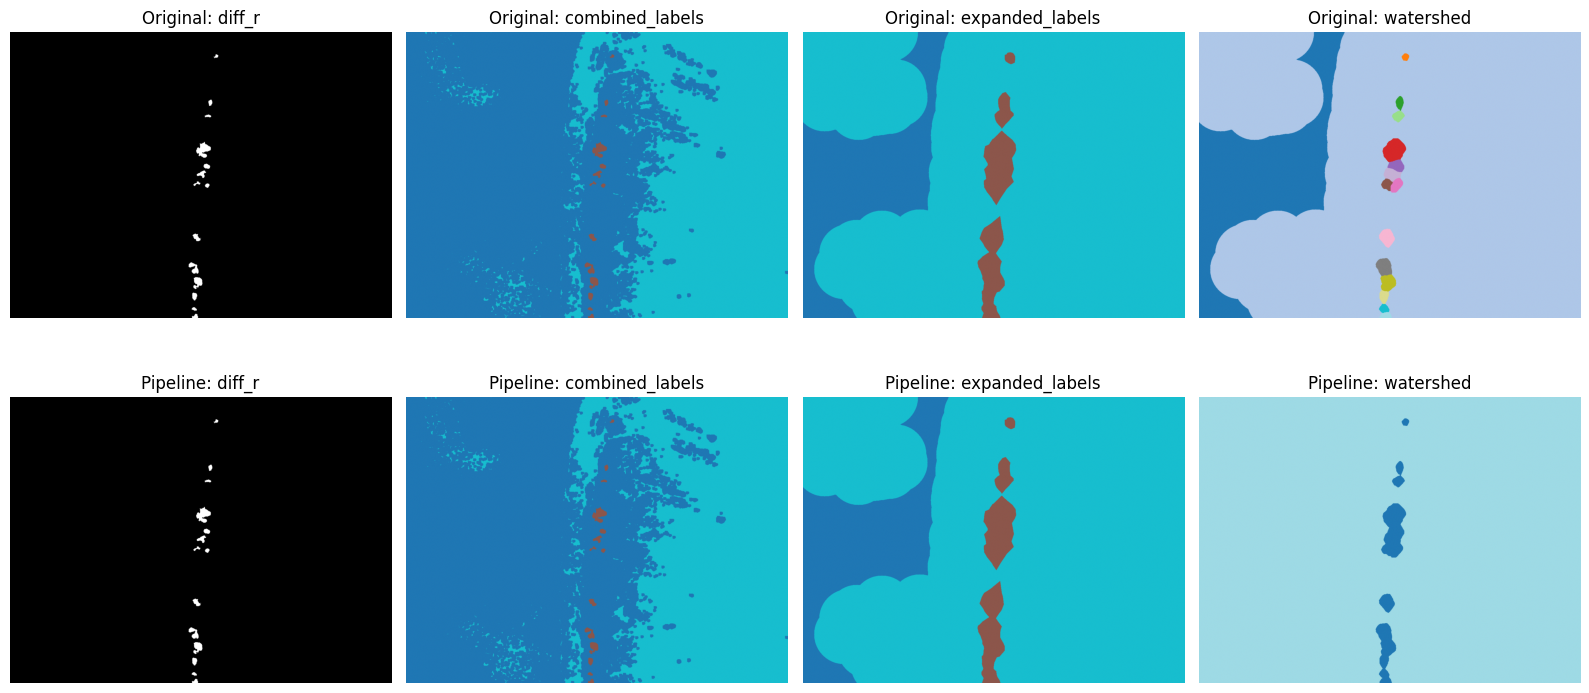

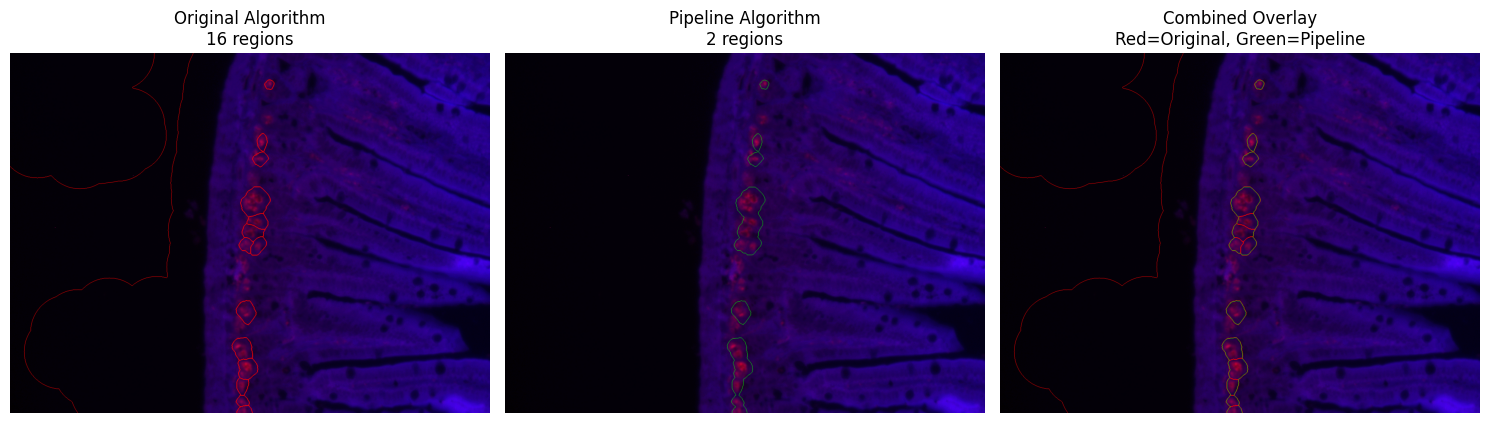

In [62]:
# VISUALIZATION OF RESULTS
print("=" * 60)
print("CREATING COMPARISON VISUALIZATIONS")
print("=" * 60)

# Create side-by-side comparison
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Row 1: Original algorithm results
row = 0
axes[row, 0].imshow(orig_results['diff_r'], cmap='gray')
axes[row, 0].set_title('Original: diff_r')
axes[row, 0].axis('off')

axes[row, 1].imshow(orig_results['combined_labels'], cmap='tab10')
axes[row, 1].set_title('Original: combined_labels')
axes[row, 1].axis('off')

axes[row, 2].imshow(orig_results['expanded_labels'], cmap='tab10')
axes[row, 2].set_title('Original: expanded_labels')
axes[row, 2].axis('off')

axes[row, 3].imshow(orig_results['ws_labels'], cmap='tab20')
axes[row, 3].set_title('Original: watershed')
axes[row, 3].axis('off')

# Row 2: Pipeline results
row = 1
if 'diff_r' in debug_info:
    axes[row, 0].imshow(debug_info['diff_r'], cmap='gray')
    axes[row, 0].set_title('Pipeline: diff_r')
    axes[row, 0].axis('off')

if 'combined_labels' in debug_info:
    axes[row, 1].imshow(debug_info['combined_labels'], cmap='tab10')
    axes[row, 1].set_title('Pipeline: combined_labels')
    axes[row, 1].axis('off')

if 'expanded_labels' in debug_info:
    axes[row, 2].imshow(debug_info['expanded_labels'], cmap='tab10')
    axes[row, 2].set_title('Pipeline: expanded_labels')
    axes[row, 2].axis('off')

axes[row, 3].imshow(ws_labels_pipeline, cmap='tab20')
axes[row, 3].set_title('Pipeline: watershed')
axes[row, 3].axis('off')

plt.tight_layout()
plt.show()

# Overlay comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original overlay
boundaries_orig = find_boundaries(orig_results['ws_labels'], mode='inner')
overlay_orig = orig_results['disp'].copy()
overlay_orig[boundaries_orig] = [255, 0, 0]

axes[0].imshow(overlay_orig)
axes[0].set_title(f'Original Algorithm\n{len(np.unique(orig_results["ws_labels"]))} regions')
axes[0].axis('off')

# Pipeline overlay
boundaries_pipeline = find_boundaries(ws_labels_pipeline, mode='inner')
overlay_pipeline = orig_results['disp'].copy()
overlay_pipeline[boundaries_pipeline] = [0, 255, 0]

axes[1].imshow(overlay_pipeline)
axes[1].set_title(f'Pipeline Algorithm\n{len(np.unique(ws_labels_pipeline))} regions')
axes[1].axis('off')

# Combined overlay (red=original, green=pipeline)
overlay_combined = orig_results['disp'].copy()
overlay_combined[boundaries_orig] = [255, 0, 0]    # Red for original
overlay_combined[boundaries_pipeline] = [0, 255, 0]  # Green for pipeline

axes[2].imshow(overlay_combined)
axes[2].set_title('Combined Overlay\nRed=Original, Green=Pipeline')
axes[2].axis('off')

plt.tight_layout()
plt.show()

In [63]:
# DIAGNOSTIC ANALYSIS
print("=" * 60)
print("DIAGNOSTIC ANALYSIS AND RECOMMENDATIONS")
print("=" * 60)

# Analyze where the differences occur
if not np.array_equal(orig_results['ws_labels'], ws_labels_pipeline):
    print("❌ ALGORITHMS PRODUCE DIFFERENT RESULTS")
    
    # Find first point of divergence
    divergence_found = False
    
    # Check each step
    check_steps = [
        ('red channels', red_orig_extracted, debug_info.get('red_from_disp')),
        ('blue channels', blue_orig_extracted, debug_info.get('blue_from_disp')),
        ('diff_r', orig_results['diff_r'], debug_info.get('diff_r')),
        ('mask_gt_red_eroded', orig_results['mask_gt_red_eroded'], debug_info.get('mask_gt_red_eroded')),
        ('combined_labels', orig_results['combined_labels'], debug_info.get('combined_labels')),
        ('expanded_labels', orig_results['expanded_labels'], debug_info.get('expanded_labels')),
        ('final_labels', orig_results['ws_labels'], ws_labels_pipeline)
    ]
    
    for step_name, orig_data, pipeline_data in check_steps:
        if orig_data is not None and pipeline_data is not None:
            if isinstance(orig_data, np.ndarray) and isinstance(pipeline_data, np.ndarray):
                if not np.array_equal(orig_data, pipeline_data):
                    print(f"🔍 DIVERGENCE FOUND at: {step_name}")
                    print(f"   Original shape: {orig_data.shape}, dtype: {orig_data.dtype}")
                    print(f"   Pipeline shape: {pipeline_data.shape}, dtype: {pipeline_data.dtype}")
                    if orig_data.dtype == bool:
                        print(f"   Original True pixels: {np.sum(orig_data)}")
                        print(f"   Pipeline True pixels: {np.sum(pipeline_data)}")
                    else:
                        print(f"   Original unique values: {len(np.unique(orig_data))}")
                        print(f"   Pipeline unique values: {len(np.unique(pipeline_data))}")
                        print(f"   Original range: [{orig_data.min()}, {orig_data.max()}]")
                        print(f"   Pipeline range: [{pipeline_data.min()}, {pipeline_data.max()}]")
                    divergence_found = True
                    break
                else:
                    print(f"✓ {step_name}: IDENTICAL")
            else:
                print(f"⚠ {step_name}: Cannot compare (type mismatch)")
        else:
            print(f"⚠ {step_name}: Missing data")
    
    if not divergence_found:
        print("🤔 No clear divergence point found - may be floating point precision issue")

else:
    print("✅ ALGORITHMS PRODUCE IDENTICAL RESULTS!")

# Summary statistics
print(f"\nSUMMARY:")
print(f"Original algorithm found: {len(np.unique(orig_results['ws_labels']))} regions")
print(f"Pipeline algorithm found: {len(np.unique(ws_labels_pipeline))} regions")
print(f"Test image: {test_red_path.name}")

DIAGNOSTIC ANALYSIS AND RECOMMENDATIONS
❌ ALGORITHMS PRODUCE DIFFERENT RESULTS
✓ red channels: IDENTICAL
✓ blue channels: IDENTICAL
✓ diff_r: IDENTICAL
✓ mask_gt_red_eroded: IDENTICAL
✓ combined_labels: IDENTICAL
✓ expanded_labels: IDENTICAL
🔍 DIVERGENCE FOUND at: final_labels
   Original shape: (960, 1280), dtype: int32
   Pipeline shape: (960, 1280), dtype: int32
   Original unique values: 16
   Pipeline unique values: 2
   Original range: [0, 15]
   Pipeline range: [-1, 0]

SUMMARY:
Original algorithm found: 16 regions
Pipeline algorithm found: 2 regions
Test image: G2EL - 1_RFP.tif


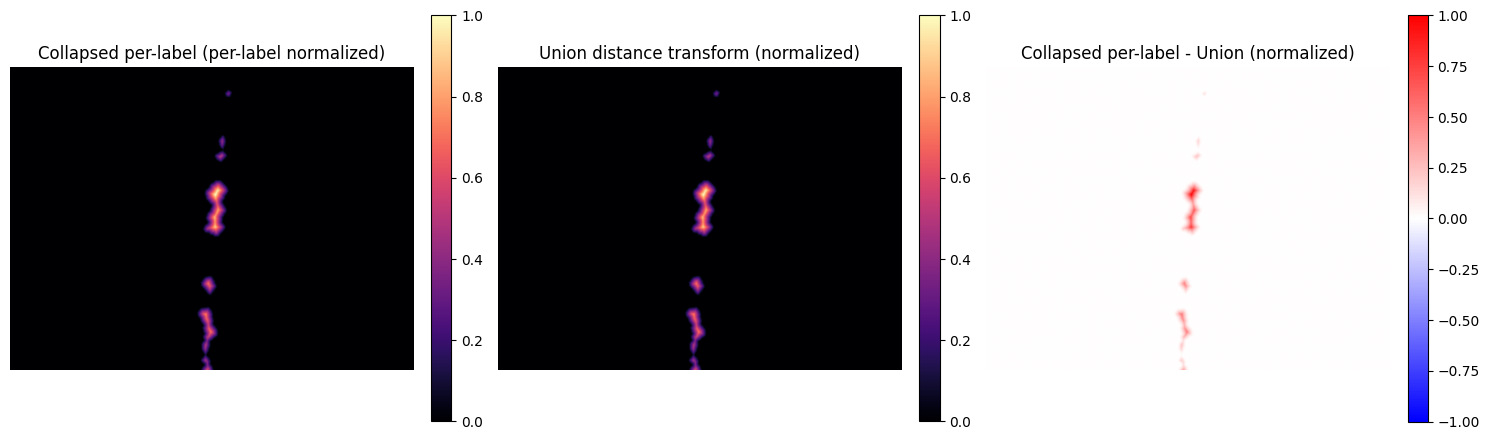

In [64]:
# set all labels equal to 1 to 0 (in-place)
ws_labels_pipeline[ws_labels_pipeline == 1] = 0
#plt.imshow(ws_labels_pipeline)
# Distance transforms per-label and for all non-zero labels together


# Distance transforms per-label, union, and collapsed visualization

labels = np.unique(ws_labels_pipeline)
labels = labels[labels != 0]  # exclude background

h, w = ws_labels_pipeline.shape
dt_collapsed = np.zeros((h, w), dtype=float)   # will hold per-label normalized distances, collapsed
dt_per_label_max = {}                            # store max distance per label (optional)
dt_maps = {}                                     # store raw dt maps per label (optional)

if len(labels) == 0:
    print("No non-zero labels found in ws_labels_pipeline.")
else:
    for lab in labels:
        mask = (ws_labels_pipeline == lab)
        if not np.any(mask):
            continue
        # distance inside the label to the label boundary (distance to nearest False)
        dt = distance_transform_edt(mask)
        dt_maps[lab] = dt
        m = dt.max()
        dt_per_label_max[lab] = m
        if m > 0:
            dt_norm = dt / m   # normalize per-label so every label uses full dynamic range
        else:
            dt_norm = dt
        # collapse: keep normalized distances only where the label is present
        dt_collapsed[mask] = dt_norm[mask]

# union distance transform (all non-zero labels together)
union_mask = (ws_labels_pipeline != 0)
if np.any(union_mask):
    dt_union = distance_transform_edt(union_mask)
    # normalize for visualization
    dt_union_norm = dt_union / (dt_union.max() if dt_union.max() > 0 else 1.0)
else:
    dt_union = np.zeros_like(ws_labels_pipeline, dtype=float)
    dt_union_norm = dt_union

# Visualize collapsed per-label DT and union DT side-by-side
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
im0 = axes[0].imshow(dt_collapsed, cmap='magma')
axes[0].set_title('Collapsed per-label (per-label normalized)')
axes[0].axis('off')
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

im1 = axes[1].imshow(dt_union_norm, cmap='magma')
axes[1].set_title('Union distance transform (normalized)')
axes[1].axis('off')
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

# Difference (useful to spot where per-label normalization hides absolute differences)
# compute per-pixel difference between per-label normalized collapsed and union normalized
diff = dt_collapsed * dt_union_norm
im2 = axes[2].imshow(diff, cmap='bwr', vmin=-1, vmax=1)
axes[2].set_title('Collapsed per-label - Union (normalized)')
axes[2].axis('off')
plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()




In [65]:
# Create normalized red channel for comparison
red_norm = red_orig_extracted / red_orig_extracted.max()

# Calculate absolute differences between normalized red and distance transforms
abs_diff_union = np.abs(red_norm - dt_union_norm)
abs_diff_collapsed = np.abs(red_norm - dt_collapsed)

print(f"Created abs_diff variables:")
print(f"  abs_diff_union shape: {abs_diff_union.shape}, range: [{abs_diff_union.min():.4f}, {abs_diff_union.max():.4f}]")
print(f"  abs_diff_collapsed shape: {abs_diff_collapsed.shape}, range: [{abs_diff_collapsed.min():.4f}, {abs_diff_collapsed.max():.4f}]")

Created abs_diff variables:
  abs_diff_union shape: (960, 1280), range: [0.0000, 1.0000]
  abs_diff_collapsed shape: (960, 1280), range: [0.0000, 1.0000]


In [66]:
# Normalize red_orig_extracted to 0-1 and compare distances to dt_union_norm vs dt_collapsed
mask = (ws_labels_pipeline > 0)
n_pixels = int(np.count_nonzero(mask))
print(f"Pixels with ws_labels_pipeline > 0: {n_pixels}")

if n_pixels == 0:
    print("No pixels found where ws_labels_pipeline > 0.")
else:
    eps = 1e-12
    red = red_orig_extracted.astype(float, copy=False)
    lo, hi = red.min(), red.max()
    red_norm = (red - lo) / max(hi - lo, eps)        # global 0-1 normalization

    # Ensure dt maps are present and same shape
    assert dt_union_norm.shape == red_norm.shape == dt_collapsed.shape, "Shape mismatch"

    # Per-pixel absolute distances
    abs_diff_union = np.abs(red_norm - dt_union_norm)
    abs_diff_collapsed = np.abs(red_norm - dt_collapsed)

    # Stats over masked pixels
    union_vals = abs_diff_union[mask]
    collapsed_vals = abs_diff_collapsed[mask]
    print("Distance stats (over masked pixels):")
    print(f"  dt_union_norm -> mean: {union_vals.mean():.4f}, median: {np.median(union_vals):.4f}, max: {union_vals.max():.4f}")
    print(f"  dt_collapsed  -> mean: {collapsed_vals.mean():.4f}, median: {np.median(collapsed_vals):.4f}, max: {collapsed_vals.max():.4f}")

    # Which is closer per-pixel
    closer_union = (union_vals < collapsed_vals)
    closer_collapsed = (collapsed_vals < union_vals)
    ties = np.isclose(union_vals, collapsed_vals, atol=1e-9)
    print(f"  Pixels where dt_union closer: {closer_union.sum()} ({100*closer_union.mean():.2f}%)")
    print(f"  Pixels where dt_collapsed closer: {closer_collapsed.sum()} ({100*closer_collapsed.mean():.2f}%)")
    print(f"  Ties (nearly equal): {ties.sum()} ({100*ties.mean():.2f}%)")

    # Visualize: normalized red, and absolute difference maps (masked)
    fig, axes = plt.subplots(1, 4, figsize=(18, 5))
    mred = np.ma.masked_where(~mask, red_norm)
    im0 = axes[0].imshow(mred, cmap='viridis', vmin=0, vmax=1)
    axes[0].set_title('red_norm (0-1) where ws_labels_pipeline>0')
    axes[0].axis('off')
    plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

    md1 = np.ma.masked_where(~mask, abs_diff_union)
    im1 = axes[1].imshow(md1, cmap='magma')
    axes[1].set_title('abs(red_norm - dt_union_norm)')
    axes[1].axis('off')
    plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

    md2 = np.ma.masked_where(~mask, abs_diff_collapsed)
    im2 = axes[2].imshow(md2, cmap='magma')
    axes[2].set_title('abs(red_norm - dt_collapsed)')
    axes[2].axis('off')
    plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

    # Histogram comparison of absolute differences
    axes[3].hist(union_vals.ravel(), bins=50, alpha=0.6, label='union', color='C1', density=False)
    axes[3].hist(collapsed_vals.ravel(), bins=50, alpha=0.6, label='collapsed', color='C2', density=False)
    axes[3].set_title('Histogram of abs differences (masked)')
    axes[3].legend()
    axes[3].set_xlabel('Absolute difference')
    axes[3].set_ylabel('Count')

    plt.tight_layout()
    plt.show()

    # Optional: scatter (sample points to avoid huge plot)
    sample_idx = np.nonzero(mask)[0]
    if sample_idx.size > 5000:
        rng = np.random.default_rng(0)
        choice = rng.choice(sample_idx, size=5000, replace=False)
    else:
        choice = sample_idx
    # flatten indices and sample
    ys, xs = np.nonzero(mask)
    sel_y = ys if ys.size <= 5000 else ys[choice]
    sel_x = xs if xs.size <= 5000 else xs[choice]
    sel_red = red_norm[sel_y, sel_x]
    sel_du = dt_union_norm[sel_y, sel_x]
    sel_dc = dt_collapsed[sel_y, sel_x]

    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    ax[0].scatter(sel_red, sel_du, s=4, alpha=0.4)
    ax[0].set_xlabel('red_norm')
    ax[0].set_ylabel('dt_union_norm')
    ax[0].set_title('red_norm vs dt_union_norm')

    ax[1].scatter(sel_red, sel_dc, s=4, alpha=0.4, color='C2')
    ax[1].set_xlabel('red_norm')
    ax[1].set_ylabel('dt_collapsed')
    ax[1].set_title('red_norm vs dt_collapsed')

    plt.tight_layout()
    plt.show()

Pixels with ws_labels_pipeline > 0: 0
No pixels found where ws_labels_pipeline > 0.


DISTANCE-BASED MERGING ANALYSIS
Merging benefit range: [0.0000, 0.0000]
Pixels where merging would help: 0 (nan%)


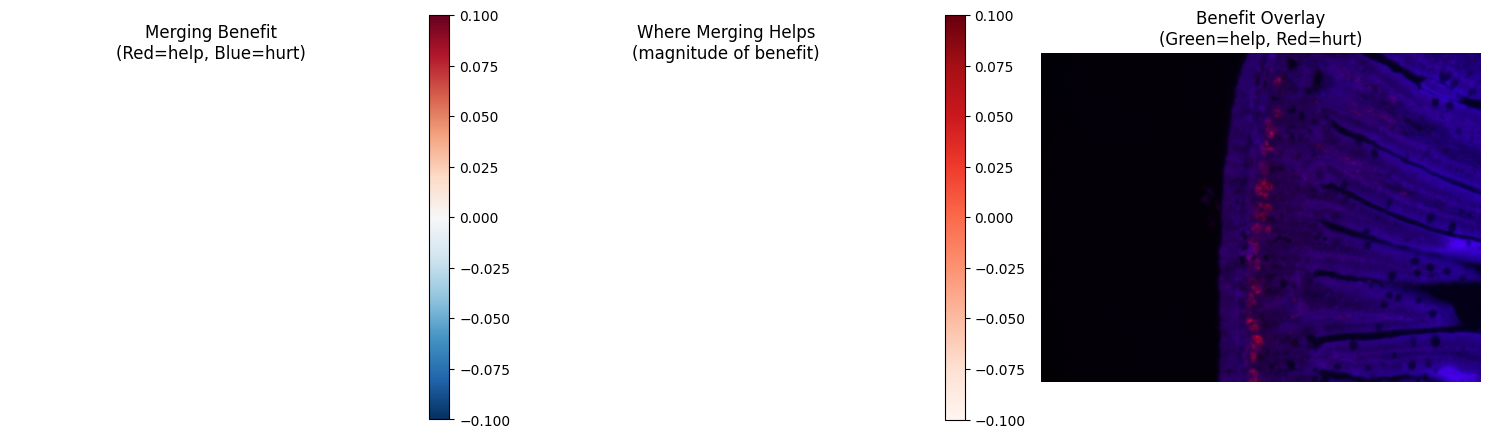

In [67]:
# Explore using distance transform differences for merging decisions
print("=" * 60)
print("DISTANCE-BASED MERGING ANALYSIS")
print("=" * 60)

# The key insight: 
# - dt_union_norm represents what the distance would be if regions were merged
# - dt_collapsed represents current per-label normalized distances
# - red_norm is the actual intensity we're trying to match
# - If red_norm is closer to dt_union_norm than dt_collapsed, merging might improve the fit

# Create a "merging benefit" metric per pixel
# Positive values = merging would improve fit to red intensity
# Negative values = merging would worsen fit
merging_benefit = abs_diff_collapsed - abs_diff_union  # Fixed: subtraction, not multiplication
print(f"Merging benefit range: [{merging_benefit.min():.4f}, {merging_benefit.max():.4f}]")

# Stats over masked pixels
mask = (ws_labels_pipeline > 0)
benefit_vals = merging_benefit[mask]
positive_benefit = benefit_vals > 0
print(f"Pixels where merging would help: {positive_benefit.sum()} ({100*positive_benefit.mean():.2f}%)")
if positive_benefit.sum() > 0:
    print(f"Mean benefit where positive: {benefit_vals[positive_benefit].mean():.4f}")
if np.sum(~positive_benefit) > 0:
    print(f"Mean penalty where negative: {benefit_vals[~positive_benefit].mean():.4f}")

# Visualize merging benefit map
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Show raw merging benefit (masked)
masked_benefit = np.ma.masked_where(~mask, merging_benefit)
# Adjust color scale based on actual data range
vmax = max(abs(merging_benefit.min()), abs(merging_benefit.max()))
im0 = axes[0].imshow(masked_benefit, cmap='RdBu_r', vmin=-vmax, vmax=vmax)
axes[0].set_title('Merging Benefit\n(Red=help, Blue=hurt)')
axes[0].axis('off')
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

# Show only positive benefits (where merging helps)
positive_benefit_map = np.where(merging_benefit > 0, merging_benefit, 0)
masked_positive = np.ma.masked_where(~mask, positive_benefit_map)
im1 = axes[1].imshow(masked_positive, cmap='Reds')
axes[1].set_title('Where Merging Helps\n(magnitude of benefit)')
axes[1].axis('off')
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

# Overlay on original image
overlay_benefit = disp.copy()
# Color pixels where merging would help in green
benefit_threshold = np.percentile(benefit_vals[benefit_vals > 0], 75) if np.sum(benefit_vals > 0) > 0 else 0.01
help_pixels = (merging_benefit > benefit_threshold) & mask  # threshold for significance
overlay_benefit[help_pixels] = [0, 255, 0]
# Color pixels where merging would hurt in red
hurt_threshold = np.percentile(benefit_vals[benefit_vals < 0], 25) if np.sum(benefit_vals < 0) > 0 else -0.01
hurt_pixels = (merging_benefit < hurt_threshold) & mask
overlay_benefit[hurt_pixels] = [255, 0, 0]

axes[2].imshow(overlay_benefit)
axes[2].set_title('Benefit Overlay\n(Green=help, Red=hurt)')
axes[2].axis('off')

plt.tight_layout()
plt.show()

In [68]:
# Advanced Per-Region Scoring System: DST vs RFP Analysis for Over-Segmentation Detection
print("=" * 80)
print("ADVANCED PER-REGION SCORING: DST vs RFP ANALYSIS")
print("=" * 80)

from scipy.stats import spearmanr, kendalltau
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

def simple_wasserstein_distance(u_values, v_values):
    """
    Simple approximation of Wasserstein distance using cumulative distributions.
    """
    try:
        # Sort both distributions
        u_sorted = np.sort(u_values)
        v_sorted = np.sort(v_values)
        
        # Make them the same length by interpolation
        if len(u_sorted) != len(v_sorted):
            n_points = min(len(u_sorted), len(v_sorted), 100)  # Limit for efficiency
            u_interp = np.interp(np.linspace(0, 1, n_points), 
                                np.linspace(0, 1, len(u_sorted)), u_sorted)
            v_interp = np.interp(np.linspace(0, 1, n_points), 
                                np.linspace(0, 1, len(v_sorted)), v_sorted)
        else:
            u_interp = u_sorted
            v_interp = v_sorted
        
        # Wasserstein distance is the L1 distance between CDFs
        return np.mean(np.abs(u_interp - v_interp))
    except:
        return 0.0

def compute_region_centroid_shift(region_mask, rfp_values):
    """
    Compute centroid shift between geometric center and RFP-weighted center.
    Returns normalized magnitude and direction vector.
    """
    if not np.any(region_mask):
        return 0.0, np.array([0.0, 0.0])
    
    # Geometric centroid
    coords = np.argwhere(region_mask)
    if len(coords) == 0:
        return 0.0, np.array([0.0, 0.0])
    
    geo_centroid = coords.mean(axis=0)
    
    # RFP-weighted centroid
    rfp_masked = rfp_values[region_mask]
    if len(rfp_masked) == 0 or np.sum(rfp_masked) == 0:
        return 0.0, np.array([0.0, 0.0])
    
    weights = rfp_masked / np.sum(rfp_masked)
    rfp_centroid = (coords * weights[:, np.newaxis]).sum(axis=0)
    
    # Shift vector
    shift_vector = rfp_centroid - geo_centroid
    
    # Normalize by equivalent radius
    area = np.sum(region_mask)
    equiv_radius = np.sqrt(area / np.pi)
    
    if equiv_radius > 0:
        normalized_magnitude = np.linalg.norm(shift_vector) / equiv_radius
    else:
        normalized_magnitude = 0.0
    
    return normalized_magnitude, shift_vector

def compute_dst_rfp_rank_correlation(dst_values, rfp_values, region_mask):
    """
    Compute Spearman rank correlation between DST and RFP within region.
    """
    if not np.any(region_mask):
        return 0.0, 1.0
    
    dst_region = dst_values[region_mask]
    rfp_region = rfp_values[region_mask]
    
    if len(dst_region) < 3:  # Need at least 3 points for correlation
        return 0.0, 1.0
    
    try:
        correlation, p_value = spearmanr(dst_region, rfp_region)
        if np.isnan(correlation):
            correlation = 0.0
        return correlation, p_value
    except:
        return 0.0, 1.0

def compute_principal_axis_skew(region_mask, rfp_values):
    """
    Compute RFP skew along principal axis using simplified EMD.
    """
    if not np.any(region_mask):
        return 0.0
    
    coords = np.argwhere(region_mask)
    if len(coords) < 3:
        return 0.0
    
    try:
        # PCA to find principal axis
        pca = PCA(n_components=1)
        coords_centered = coords - coords.mean(axis=0)
        pca.fit(coords_centered)
        
        # Project coordinates to PC1
        pc1_coords = pca.transform(coords_centered).flatten()
        
        # Normalize to [0, 1]
        coord_range = pc1_coords.max() - pc1_coords.min()
        if coord_range == 0:
            return 0.0
        
        pc1_normalized = (pc1_coords - pc1_coords.min()) / coord_range
        
        # RFP weights for each coordinate
        rfp_region = rfp_values[region_mask]
        
        # Create weighted coordinates by sampling
        n_samples = min(len(pc1_normalized), 500)  # Limit for efficiency
        rfp_weights = rfp_region / (np.sum(rfp_region) + 1e-12)
        
        # Sample coordinates according to RFP weights
        try:
            weighted_coords = np.random.choice(pc1_normalized, size=n_samples, 
                                             p=rfp_weights/np.sum(rfp_weights))
        except:
            # If sampling fails, use simple weighted mean comparison
            uniform_mean = np.mean(pc1_normalized)
            weighted_mean = np.average(pc1_normalized, weights=rfp_weights)
            return abs(weighted_mean - uniform_mean) / coord_range
        
        # Use our simple Wasserstein distance
        emd = simple_wasserstein_distance(pc1_normalized, weighted_coords)
        
        # Normalize by axis length
        normalized_emd = emd / coord_range if coord_range > 0 else 0.0
        return normalized_emd
    
    except:
        return 0.0

def compute_binned_dst_rfp_analysis(dst_values, rfp_values, region_mask, n_bins=10):
    """
    Bin DST into deciles and analyze RFP distribution per bin.
    Returns Kendall tau, R², and front-back contrast.
    """
    if not np.any(region_mask):
        return 0.0, 0.0, 0.0
    
    dst_region = dst_values[region_mask]
    rfp_region = rfp_values[region_mask]
    
    if len(dst_region) < 3:
        return 0.0, 0.0, 0.0
    
    try:
        # Create bins based on DST percentiles
        bin_edges = np.percentile(dst_region, np.linspace(0, 100, n_bins + 1))
        
        # Ensure unique bin edges
        bin_edges = np.unique(bin_edges)
        if len(bin_edges) < 2:
            return 0.0, 0.0, 0.0
        
        # Assign pixels to bins
        bin_indices = np.digitize(dst_region, bin_edges) - 1
        bin_indices = np.clip(bin_indices, 0, len(bin_edges) - 2)
        
        # Compute mean RFP per bin
        bin_means = []
        bin_centers = []
        
        for i in range(len(bin_edges) - 1):
            bin_mask = (bin_indices == i)
            if np.any(bin_mask):
                bin_means.append(np.mean(rfp_region[bin_mask]))
                bin_centers.append((bin_edges[i] + bin_edges[i + 1]) / 2)
        
        if len(bin_means) < 3:
            return 0.0, 0.0, 0.0
        
        bin_means = np.array(bin_means)
        bin_centers = np.array(bin_centers)
        
        # Kendall tau
        try:
            kendall_tau, _ = kendalltau(bin_centers, bin_means)
            if np.isnan(kendall_tau):
                kendall_tau = 0.0
        except:
            kendall_tau = 0.0
        
        # R² of linear fit
        try:
            model = LinearRegression()
            model.fit(bin_centers.reshape(-1, 1), bin_means)
            r2 = r2_score(bin_means, model.predict(bin_centers.reshape(-1, 1)))
            if np.isnan(r2):
                r2 = 0.0
        except:
            r2 = 0.0
        
        # Front-back contrast (top 20% vs bottom 20%)
        try:
            n_bins_total = len(bin_means)
            n_top = max(1, int(0.2 * n_bins_total))
            n_bottom = max(1, int(0.2 * n_bins_total))
            
            top_bins = bin_means[-n_top:]
            bottom_bins = bin_means[:n_bottom]
            
            contrast = np.mean(top_bins) - np.mean(bottom_bins)
        except:
            contrast = 0.0
        
        return kendall_tau, r2, contrast
    
    except:
        return 0.0, 0.0, 0.0

def analyze_region_oversegmentation(region_id, labels_array, dst_values, rfp_values):
    """
    Complete analysis of a single region for over-segmentation indicators.
    """
    region_mask = (labels_array == region_id)
    
    if not np.any(region_mask):
        return {
            'region_id': region_id,
            'centroid_shift_magnitude': 0.0,
            'centroid_shift_vector': np.array([0.0, 0.0]),
            'dst_rfp_correlation': 0.0,
            'dst_rfp_p_value': 1.0,
            'principal_axis_skew': 0.0,
            'kendall_tau': 0.0,
            'binned_r2': 0.0,
            'front_back_contrast': 0.0,
            'n_pixels': 0,
            'oversegmentation_score': 0.0
        }
    
    # 1. Centroid shift analysis
    centroid_magnitude, centroid_vector = compute_region_centroid_shift(region_mask, rfp_values)
    
    # 2. DST-RFP rank correlation
    dst_rfp_corr, dst_rfp_p = compute_dst_rfp_rank_correlation(dst_values, rfp_values, region_mask)
    
    # 3. Principal axis skew
    pc_skew = compute_principal_axis_skew(region_mask, rfp_values)
    
    # 4. Binned DST-RFP analysis
    kendall_tau, binned_r2, fb_contrast = compute_binned_dst_rfp_analysis(dst_values, rfp_values, region_mask)
    
    # 5. Composite over-segmentation score
    # High score = likely over-segmented
    overseg_score = (
        centroid_magnitude * 0.3 +           # RFP mass off-center
        (1 - abs(dst_rfp_corr)) * 0.2 +      # Weak DST-RFP correlation
        pc_skew * 0.3 +                      # RFP skewed along main axis
        (1 - abs(kendall_tau)) * 0.1 +       # Non-monotonic DST-RFP relationship
        (1 - binned_r2) * 0.1                # Poor linear fit
    )
    
    return {
        'region_id': region_id,
        'centroid_shift_magnitude': centroid_magnitude,
        'centroid_shift_vector': centroid_vector,
        'dst_rfp_correlation': dst_rfp_corr,
        'dst_rfp_p_value': dst_rfp_p,
        'principal_axis_skew': pc_skew,
        'kendall_tau': kendall_tau,
        'binned_r2': binned_r2,
        'front_back_contrast': fb_contrast,
        'n_pixels': np.sum(region_mask),
        'oversegmentation_score': overseg_score
    }

# Analyze all regions
print("Analyzing all regions for over-segmentation indicators...")

# Prepare distance transforms (use our existing collapsed per-label normalized version)
dst_analysis = dt_collapsed.copy()
rfp_analysis = red_orig_extracted.copy()

# Normalize RFP globally for analysis
rfp_min, rfp_max = rfp_analysis.min(), rfp_analysis.max()
if rfp_max > rfp_min:
    rfp_analysis = (rfp_analysis - rfp_min) / (rfp_max - rfp_min)

# Get all non-zero regions
analysis_regions = np.unique(ws_labels_pipeline)
analysis_regions = analysis_regions[analysis_regions != 0]

# Analyze each region
region_analyses = []
for region_id in analysis_regions:
    analysis = analyze_region_oversegmentation(region_id, ws_labels_pipeline, dst_analysis, rfp_analysis)
    region_analyses.append(analysis)
    
print(f"Analyzed {len(region_analyses)} regions")

# Convert to DataFrame for easier analysis
import pandas as pd
df_analysis = pd.DataFrame(region_analyses)

# Sort by over-segmentation score (highest first)
df_sorted = df_analysis.sort_values('oversegmentation_score', ascending=False)

print(f"\nTop 5 regions with highest over-segmentation scores:")
print("-" * 60)
for idx, row in df_sorted.head().iterrows():
    print(f"Region {row['region_id']:2d}: score={row['oversegmentation_score']:.3f}")
    print(f"  Centroid shift: {row['centroid_shift_magnitude']:.3f}")
    print(f"  DST-RFP corr:   {row['dst_rfp_correlation']:6.3f} (p={row['dst_rfp_p_value']:.3f})")
    print(f"  PC axis skew:   {row['principal_axis_skew']:.3f}")
    print(f"  Kendall tau:    {row['kendall_tau']:6.3f}")
    print(f"  Linear R²:      {row['binned_r2']:6.3f}")
    print(f"  Pixels:         {row['n_pixels']}")
    print()

# Summary statistics
print("Summary Statistics:")
print("-" * 30)
print(f"Mean oversegmentation score: {df_analysis['oversegmentation_score'].mean():.3f}")
print(f"Std oversegmentation score:  {df_analysis['oversegmentation_score'].std():.3f}")
print(f"Regions above mean+1std:     {np.sum(df_analysis['oversegmentation_score'] > df_analysis['oversegmentation_score'].mean() + df_analysis['oversegmentation_score'].std())}")

# Store results for visualization
oversegmentation_analysis = {
    'df_analysis': df_analysis,
    'df_sorted': df_sorted,
    'dst_analysis': dst_analysis,
    'rfp_analysis': rfp_analysis
}

ADVANCED PER-REGION SCORING: DST vs RFP ANALYSIS
Analyzing all regions for over-segmentation indicators...
Analyzed 1 regions

Top 5 regions with highest over-segmentation scores:
------------------------------------------------------------
Region -1: score=0.136
  Centroid shift: 0.084
  DST-RFP corr:    0.495 (p=0.000)
  PC axis skew:   0.000
  Kendall tau:     1.000
  Linear R²:       0.896
  Pixels:         22436

Summary Statistics:
------------------------------
Mean oversegmentation score: 0.136
Std oversegmentation score:  nan
Regions above mean+1std:     0


VISUALIZATION OF ADVANCED REGION ANALYSIS


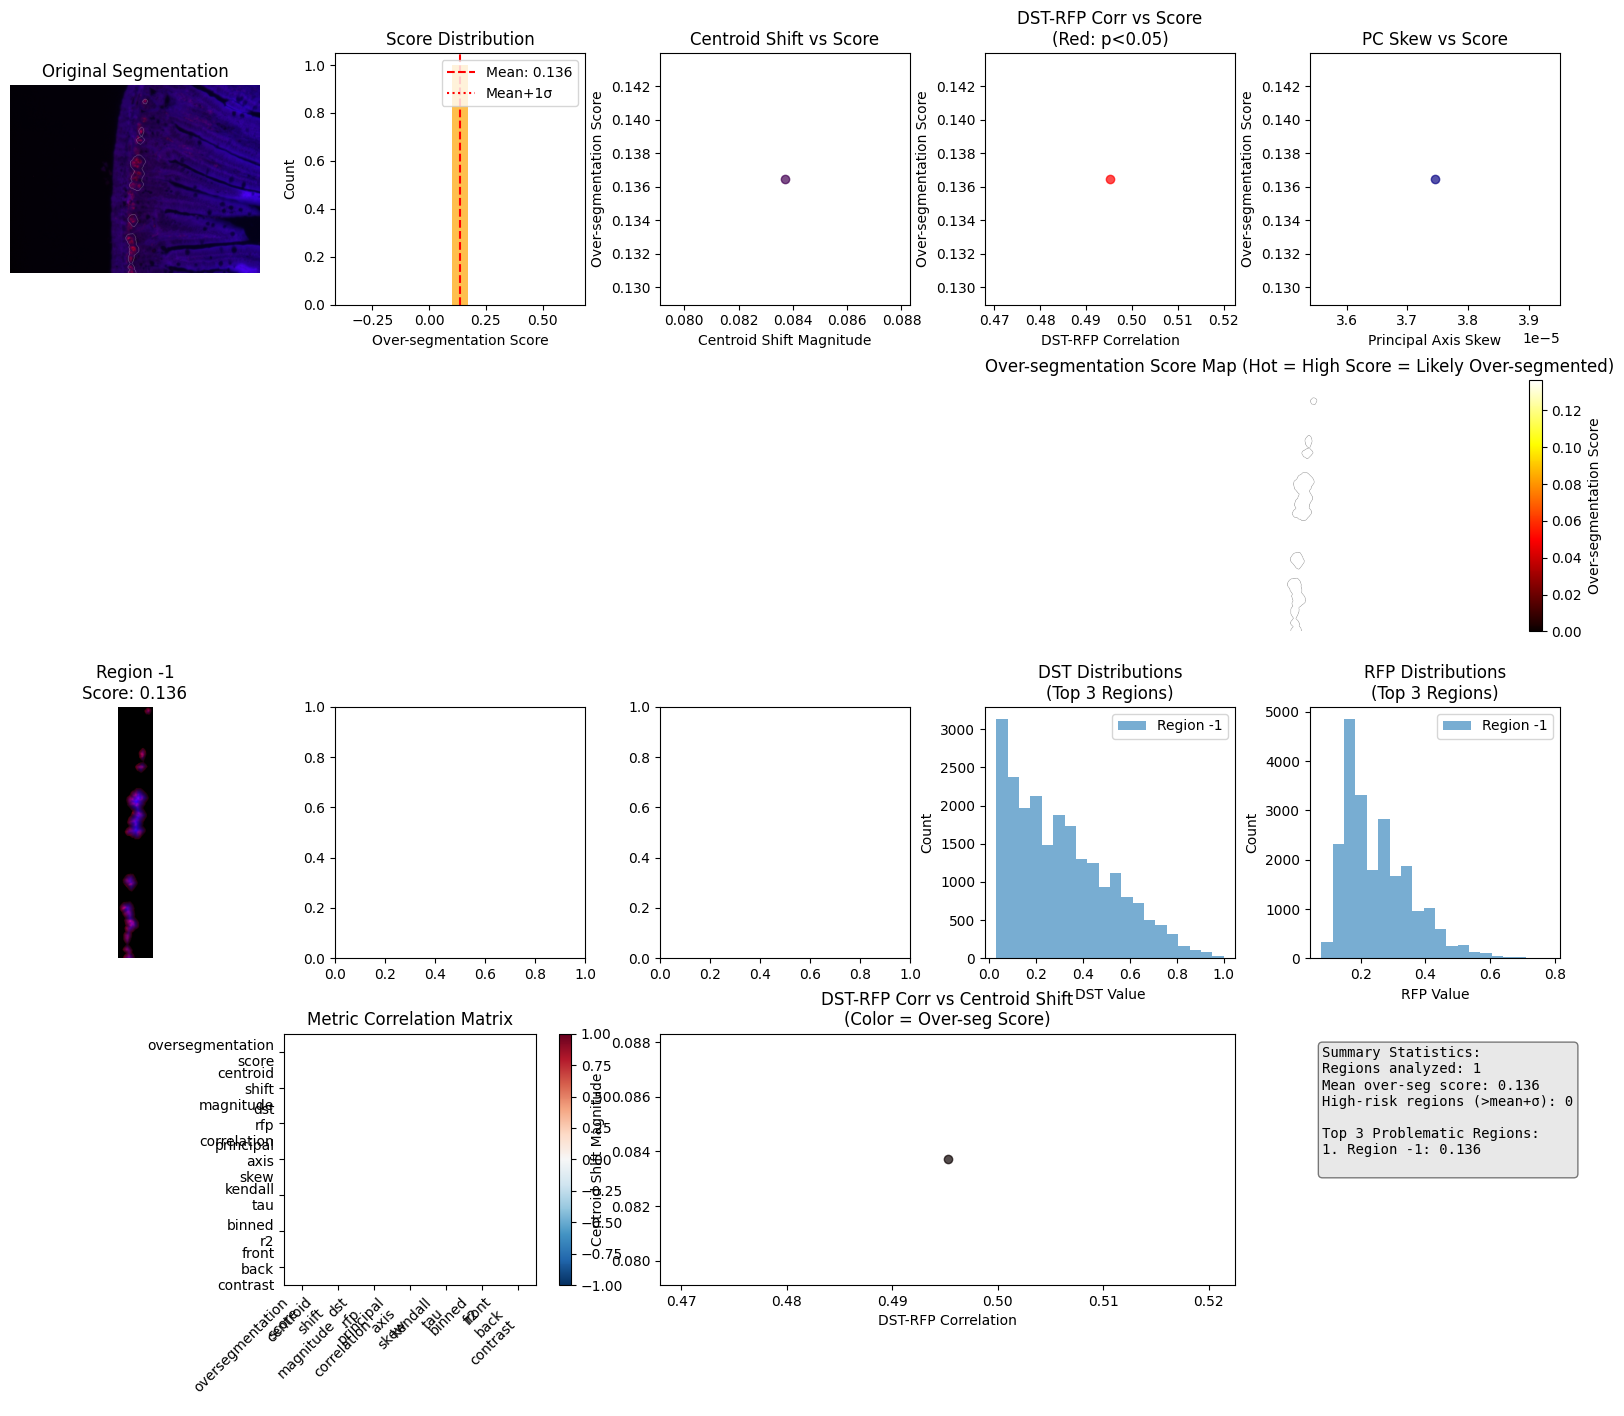


Analysis Complete!
This analysis identifies regions where:
• RFP mass is shifted away from geometric center (centroid shift)
• DST and RFP have weak correlation (poor radial symmetry)
• RFP is skewed along the principal axis (directional bias)
• DST-RFP relationship is non-monotonic (complex structure)

High-scoring regions are candidates for:
• Manual review for over-segmentation
• Merging with adjacent regions
• Alternative segmentation approaches


In [69]:
# Comprehensive Visualization of Advanced Region Analysis
print("=" * 80)
print("VISUALIZATION OF ADVANCED REGION ANALYSIS")
print("=" * 80)

# Create comprehensive visualization
fig = plt.figure(figsize=(20, 16))

# Create a custom grid layout
gs = fig.add_gridspec(4, 5, hspace=0.3, wspace=0.3)

# Row 1: Overview and score distributions
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[0, 3])
ax5 = fig.add_subplot(gs[0, 4])

# Original image with region boundaries
boundaries = find_boundaries(ws_labels_pipeline, mode='inner')
overlay = disp.copy()
overlay[boundaries] = [255, 255, 255]
ax1.imshow(overlay)
ax1.set_title('Original Segmentation')
ax1.axis('off')

# Over-segmentation score distribution
ax2.hist(df_analysis['oversegmentation_score'], bins=15, alpha=0.7, color='orange')
ax2.axvline(df_analysis['oversegmentation_score'].mean(), color='red', linestyle='--', 
           label=f'Mean: {df_analysis["oversegmentation_score"].mean():.3f}')
ax2.axvline(df_analysis['oversegmentation_score'].mean() + df_analysis['oversegmentation_score'].std(), 
           color='red', linestyle=':', label='Mean+1σ')
ax2.set_xlabel('Over-segmentation Score')
ax2.set_ylabel('Count')
ax2.set_title('Score Distribution')
ax2.legend()

# Centroid shift vs score
ax3.scatter(df_analysis['centroid_shift_magnitude'], df_analysis['oversegmentation_score'], 
           alpha=0.7, c=df_analysis['n_pixels'], cmap='viridis')
ax3.set_xlabel('Centroid Shift Magnitude')
ax3.set_ylabel('Over-segmentation Score')
ax3.set_title('Centroid Shift vs Score')

# DST-RFP correlation vs score
colors = ['red' if p < 0.05 else 'blue' for p in df_analysis['dst_rfp_p_value']]
ax4.scatter(df_analysis['dst_rfp_correlation'], df_analysis['oversegmentation_score'], 
           c=colors, alpha=0.7)
ax4.set_xlabel('DST-RFP Correlation')
ax4.set_ylabel('Over-segmentation Score')
ax4.set_title('DST-RFP Corr vs Score\n(Red: p<0.05)')

# Principal axis skew vs score
ax5.scatter(df_analysis['principal_axis_skew'], df_analysis['oversegmentation_score'], 
           alpha=0.7, c=df_analysis['n_pixels'], cmap='plasma')
ax5.set_xlabel('Principal Axis Skew')
ax5.set_ylabel('Over-segmentation Score')
ax5.set_title('PC Skew vs Score')

# Row 2: Score visualization on regions
ax6 = fig.add_subplot(gs[1, :])

# Create score visualization map
score_map = np.zeros_like(ws_labels_pipeline, dtype=float)
for _, row in df_analysis.iterrows():
    region_mask = (ws_labels_pipeline == row['region_id'])
    score_map[region_mask] = row['oversegmentation_score']

# Mask background
score_map_masked = np.ma.masked_where(ws_labels_pipeline == 0, score_map)

im = ax6.imshow(score_map_masked, cmap='hot', vmin=0, vmax=df_analysis['oversegmentation_score'].quantile(0.95))
ax6.set_title('Over-segmentation Score Map (Hot = High Score = Likely Over-segmented)')
ax6.axis('off')
cbar = plt.colorbar(im, ax=ax6, fraction=0.02, pad=0.04)
cbar.set_label('Over-segmentation Score')

# Add region labels for top scoring regions
top_regions = df_sorted.head(3)
for _, row in top_regions.iterrows():
    region_mask = (ws_labels_pipeline == row['region_id'])
    if np.any(region_mask):
        coords = np.argwhere(region_mask)
        center = coords.mean(axis=0)
        ax6.annotate(f"{int(row['region_id'])}", xy=(center[1], center[0]), 
                    xytext=(center[1]+10, center[0]-10), 
                    color='white', fontweight='bold', fontsize=12,
                    arrowprops=dict(arrowstyle='->', color='white', lw=2))

# Row 3: Detailed analysis of top 3 problematic regions
axes_row3 = [fig.add_subplot(gs[2, i]) for i in range(5)]

# Get top 3 regions for detailed analysis
top_3_regions = df_sorted.head(3)

for idx, (_, row) in enumerate(top_3_regions.iterrows()):
    if idx >= 3:
        break
    
    region_id = row['region_id']
    region_mask = (ws_labels_pipeline == region_id)
    
    if not np.any(region_mask):
        continue
    
    ax = axes_row3[idx]
    
    # Show region with DST and RFP overlay
    coords = np.argwhere(region_mask)
    y_min, y_max = coords[:, 0].min() - 5, coords[:, 0].max() + 5
    x_min, x_max = coords[:, 1].min() - 5, coords[:, 1].max() + 5
    
    # Crop to region vicinity
    crop_mask = region_mask[y_min:y_max, x_min:x_max]
    crop_dst = dst_analysis[y_min:y_max, x_min:x_max]
    crop_rfp = rfp_analysis[y_min:y_max, x_min:x_max]
    
    # Create RGB overlay: Red=RFP, Blue=DST, Green=overlap
    overlay_rgb = np.zeros((*crop_mask.shape, 3))
    overlay_rgb[..., 0] = crop_rfp  # Red channel = RFP
    overlay_rgb[..., 2] = crop_dst  # Blue channel = DST
    
    # Mask to region only
    for c in range(3):
        overlay_rgb[..., c] = np.where(crop_mask, overlay_rgb[..., c], 0)
    
    ax.imshow(overlay_rgb)
    ax.set_title(f'Region {region_id}\nScore: {row["oversegmentation_score"]:.3f}')
    ax.axis('off')
    
    # Add centroid shift arrow if significant
    if row['centroid_shift_magnitude'] > 0.1:
        # Find centroids within crop
        crop_coords = np.argwhere(crop_mask)
        if len(crop_coords) > 0:
            geo_center = crop_coords.mean(axis=0)
            
            # Approximate RFP-weighted center (simplified)
            rfp_weights = crop_rfp[crop_mask]
            if np.sum(rfp_weights) > 0:
                rfp_weights = rfp_weights / np.sum(rfp_weights)
                rfp_center = (crop_coords * rfp_weights[:, np.newaxis]).sum(axis=0)
                
                # Draw arrow from geometric to RFP center
                ax.annotate('', xy=(rfp_center[1], rfp_center[0]), 
                           xytext=(geo_center[1], geo_center[0]),
                           arrowprops=dict(arrowstyle='->', color='yellow', lw=3))

# Show DST and RFP distributions for comparison
if len(top_3_regions) > 0:
    ax_dist1 = axes_row3[3]
    ax_dist2 = axes_row3[4]
    
    # DST distributions for top 3 regions
    for idx, (_, row) in enumerate(top_3_regions.iterrows()):
        region_mask = (ws_labels_pipeline == row['region_id'])
        if np.any(region_mask):
            dst_vals = dst_analysis[region_mask]
            ax_dist1.hist(dst_vals, bins=20, alpha=0.6, label=f'Region {int(row["region_id"])}')
    
    ax_dist1.set_xlabel('DST Value')
    ax_dist1.set_ylabel('Count')
    ax_dist1.set_title('DST Distributions\n(Top 3 Regions)')
    ax_dist1.legend()
    
    # RFP distributions for top 3 regions
    for idx, (_, row) in enumerate(top_3_regions.iterrows()):
        region_mask = (ws_labels_pipeline == row['region_id'])
        if np.any(region_mask):
            rfp_vals = rfp_analysis[region_mask]
            ax_dist2.hist(rfp_vals, bins=20, alpha=0.6, label=f'Region {int(row["region_id"])}')
    
    ax_dist2.set_xlabel('RFP Value')
    ax_dist2.set_ylabel('Count')
    ax_dist2.set_title('RFP Distributions\n(Top 3 Regions)')
    ax_dist2.legend()

# Row 4: Correlation matrix and summary metrics
ax7 = fig.add_subplot(gs[3, 0:2])
ax8 = fig.add_subplot(gs[3, 2:4])
ax9 = fig.add_subplot(gs[3, 4])

# Correlation matrix of all metrics
metrics_for_corr = [
    'oversegmentation_score', 'centroid_shift_magnitude', 'dst_rfp_correlation', 
    'principal_axis_skew', 'kendall_tau', 'binned_r2', 'front_back_contrast'
]
corr_matrix = df_analysis[metrics_for_corr].corr()

im_corr = ax7.imshow(corr_matrix, cmap='RdBu_r', vmin=-1, vmax=1)
ax7.set_xticks(range(len(metrics_for_corr)))
ax7.set_yticks(range(len(metrics_for_corr)))
ax7.set_xticklabels([m.replace('_', '\n') for m in metrics_for_corr], rotation=45, ha='right')
ax7.set_yticklabels([m.replace('_', '\n') for m in metrics_for_corr])
ax7.set_title('Metric Correlation Matrix')

# Add correlation values to cells
for i in range(len(metrics_for_corr)):
    for j in range(len(metrics_for_corr)):
        text = ax7.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}', 
                       ha="center", va="center", color="black" if abs(corr_matrix.iloc[i, j]) < 0.5 else "white")

plt.colorbar(im_corr, ax=ax7, fraction=0.046, pad=0.04)

# Scatter plot matrix for key relationships
# DST-RFP correlation vs other metrics
ax8.scatter(df_analysis['dst_rfp_correlation'], df_analysis['centroid_shift_magnitude'], 
           c=df_analysis['oversegmentation_score'], cmap='hot', alpha=0.7)
ax8.set_xlabel('DST-RFP Correlation')
ax8.set_ylabel('Centroid Shift Magnitude')
ax8.set_title('DST-RFP Corr vs Centroid Shift\n(Color = Over-seg Score)')

# Summary text
summary_text = f"""Summary Statistics:
Regions analyzed: {len(df_analysis)}
Mean over-seg score: {df_analysis['oversegmentation_score'].mean():.3f}
High-risk regions (>mean+σ): {np.sum(df_analysis['oversegmentation_score'] > df_analysis['oversegmentation_score'].mean() + df_analysis['oversegmentation_score'].std())}

Top 3 Problematic Regions:
"""

for idx, (_, row) in enumerate(df_sorted.head(3).iterrows()):
    summary_text += f"{idx+1}. Region {int(row['region_id'])}: {row['oversegmentation_score']:.3f}\n"

ax9.text(0.05, 0.95, summary_text, transform=ax9.transAxes, fontsize=10, 
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.5))
ax9.axis('off')

plt.tight_layout()
plt.show()

print("\nAnalysis Complete!")
print("="*50)
print("This analysis identifies regions where:")
print("• RFP mass is shifted away from geometric center (centroid shift)")
print("• DST and RFP have weak correlation (poor radial symmetry)")
print("• RFP is skewed along the principal axis (directional bias)")
print("• DST-RFP relationship is non-monotonic (complex structure)")
print("\nHigh-scoring regions are candidates for:")
print("• Manual review for over-segmentation")
print("• Merging with adjacent regions")
print("• Alternative segmentation approaches")

In [70]:
# Intelligent Merging Recommendations Based on Advanced Scoring
print("=" * 80)
print("INTELLIGENT MERGING RECOMMENDATIONS")
print("=" * 80)

def find_intelligent_merge_candidates(df_analysis, labels_array, threshold_percentile=75):
    """
    Find merge candidates based on advanced over-segmentation scoring.
    """
    # Identify high-risk regions (above threshold percentile)
    score_threshold = np.percentile(df_analysis['oversegmentation_score'], threshold_percentile)
    high_risk_regions = df_analysis[df_analysis['oversegmentation_score'] >= score_threshold]
    
    print(f"Using over-segmentation score threshold: {score_threshold:.3f} ({threshold_percentile}th percentile)")
    print(f"High-risk regions identified: {len(high_risk_regions)}")
    
    # Build adjacency for high-risk regions only
    merge_recommendations = []
    
    for _, region_row in high_risk_regions.iterrows():
        region_id = region_row['region_id']
        region_mask = (labels_array == region_id)
        
        if not np.any(region_mask):
            continue
        
        # Find adjacent regions
        # Dilate region to find neighbors
        from scipy.ndimage import binary_dilation
        dilated = binary_dilation(region_mask, structure=np.ones((3,3)))
        neighbor_mask = dilated & ~region_mask
        neighbor_labels = np.unique(labels_array[neighbor_mask])
        neighbor_labels = neighbor_labels[neighbor_labels != 0]
        
        # Score each potential merge
        for neighbor_id in neighbor_labels:
            if neighbor_id == region_id:
                continue
                
            # Get neighbor's score
            neighbor_row = df_analysis[df_analysis['region_id'] == neighbor_id]
            if len(neighbor_row) == 0:
                continue
            neighbor_row = neighbor_row.iloc[0]
            
            # Compute merge benefit based on complementary weaknesses
            region_score = region_row['oversegmentation_score']
            neighbor_score = neighbor_row['oversegmentation_score']
            
            # Merge benefit factors:
            # 1. Both regions have high over-segmentation scores
            mutual_risk = (region_score + neighbor_score) / 2
            
            # 2. Complementary issues (different types of problems)
            centroid_complementarity = abs(region_row['centroid_shift_magnitude'] - neighbor_row['centroid_shift_magnitude'])
            correlation_complementarity = abs(region_row['dst_rfp_correlation'] - neighbor_row['dst_rfp_correlation'])
            
            # 3. Size compatibility (prefer similar sizes)
            size_ratio = min(region_row['n_pixels'], neighbor_row['n_pixels']) / max(region_row['n_pixels'], neighbor_row['n_pixels'])
            
            # Composite merge score
            merge_score = (
                mutual_risk * 0.4 +                    # Both problematic
                centroid_complementarity * 0.2 +       # Different centroid issues
                correlation_complementarity * 0.2 +    # Different correlation patterns
                size_ratio * 0.2                       # Size compatibility
            )
            
            merge_recommendations.append({
                'region_1': int(region_id),
                'region_2': int(neighbor_id),
                'region_1_score': region_score,
                'region_2_score': neighbor_score,
                'mutual_risk': mutual_risk,
                'centroid_complementarity': centroid_complementarity,
                'correlation_complementarity': correlation_complementarity,
                'size_ratio': size_ratio,
                'merge_score': merge_score,
                'region_1_pixels': int(region_row['n_pixels']),
                'region_2_pixels': int(neighbor_row['n_pixels'])
            })
    
    # Convert to DataFrame and remove duplicates
    if len(merge_recommendations) == 0:
        return pd.DataFrame()
    
    df_merges = pd.DataFrame(merge_recommendations)
    
    # Remove duplicate pairs (A,B) and (B,A)
    df_merges['pair_key'] = df_merges.apply(lambda row: tuple(sorted([row['region_1'], row['region_2']])), axis=1)
    df_merges = df_merges.drop_duplicates(subset='pair_key').drop('pair_key', axis=1)
    
    # Sort by merge score (highest first)
    df_merges = df_merges.sort_values('merge_score', ascending=False)
    
    return df_merges

# Find intelligent merge recommendations
intelligent_merges = find_intelligent_merge_candidates(df_analysis, ws_labels_pipeline, threshold_percentile=70)

print(f"\nTop intelligent merge recommendations:")
print("=" * 50)

if len(intelligent_merges) > 0:
    for idx, row in intelligent_merges.head(10).iterrows():
        print(f"Merge {idx+1}: Regions {row['region_1']} + {row['region_2']}")
        print(f"  Merge score: {row['merge_score']:.3f}")
        print(f"  Individual scores: {row['region_1_score']:.3f} + {row['region_2_score']:.3f}")
        print(f"  Sizes: {row['region_1_pixels']} + {row['region_2_pixels']} pixels")
        print(f"  Centroid complementarity: {row['centroid_complementarity']:.3f}")
        print(f"  Correlation complementarity: {row['correlation_complementarity']:.3f}")
        print(f"  Size ratio: {row['size_ratio']:.3f}")
        print()
else:
    print("No merge recommendations found with current threshold.")

# Visualize top recommendations
if len(intelligent_merges) > 0:
    print("Creating visualization of top merge recommendations...")
    
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.flatten()
    
    top_merges = intelligent_merges.head(min(10, len(intelligent_merges)))
    
    for idx, (_, row) in enumerate(top_merges.iterrows()):
        if idx >= 10:
            break
        
        ax = axes[idx]
        
        # Create visualization for this merge pair
        region_1_id = row['region_1']
        region_2_id = row['region_2']
        
        # Get combined mask
        mask_1 = (ws_labels_pipeline == region_1_id)
        mask_2 = (ws_labels_pipeline == region_2_id)
        combined_mask = mask_1 | mask_2
        
        if not np.any(combined_mask):
            ax.axis('off')
            continue
        
        # Crop to region area
        coords = np.argwhere(combined_mask)
        if len(coords) == 0:
            ax.axis('off')
            continue
        
        y_min, y_max = max(0, coords[:, 0].min() - 5), min(ws_labels_pipeline.shape[0], coords[:, 0].max() + 5)
        x_min, x_max = max(0, coords[:, 1].min() - 5), min(ws_labels_pipeline.shape[1], coords[:, 1].max() + 5)
        
        # Create colored visualization
        crop_disp = disp[y_min:y_max, x_min:x_max].copy()
        crop_labels = ws_labels_pipeline[y_min:y_max, x_min:x_max]
        
        # Highlight the two regions
        mask_1_crop = (crop_labels == region_1_id)
        mask_2_crop = (crop_labels == region_2_id)
        
        # Add colored overlays
        crop_disp[mask_1_crop] = crop_disp[mask_1_crop] * 0.7 + np.array([255, 0, 0]) * 0.3  # Red tint
        crop_disp[mask_2_crop] = crop_disp[mask_2_crop] * 0.7 + np.array([0, 255, 0]) * 0.3  # Green tint
        
        # Add boundary between regions
        from skimage.segmentation import find_boundaries
        boundary_1 = find_boundaries(mask_1_crop, mode='inner')
        boundary_2 = find_boundaries(mask_2_crop, mode='inner')
        crop_disp[boundary_1] = [255, 255, 255]
        crop_disp[boundary_2] = [255, 255, 255]
        
        ax.imshow(crop_disp.astype(np.uint8))
        ax.set_title(f'Merge {idx+1}: {region_1_id}+{region_2_id}\nScore: {row["merge_score"]:.3f}')
        ax.axis('off')
    
    # Hide unused subplots
    for idx in range(len(top_merges), 10):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

# Summary comparison with previous approaches
print("\nComparison with Previous Approaches:")
print("=" * 40)
print(f"Previous consensus merges:     {len(consensus_merges) if 'consensus_merges' in globals() else 'N/A'}")
print(f"Previous greedy merges:        {len(selected_merges) if 'selected_merges' in globals() else 'N/A'}")
print(f"New intelligent recommendations: {len(intelligent_merges)}")

if len(intelligent_merges) > 0:
    print(f"\nTop 3 intelligent merge scores: {intelligent_merges['merge_score'].head(3).tolist()}")
    print(f"Mean merge score: {intelligent_merges['merge_score'].mean():.3f}")
    print(f"Mean individual region scores: {(intelligent_merges['region_1_score'] + intelligent_merges['region_2_score']).mean() / 2:.3f}")
    
print("\nKey Advantages of Intelligent Approach:")
print("• Targets regions with specific over-segmentation indicators")
print("• Considers complementary weaknesses between regions")
print("• Balances multiple geometric and intensity-based factors")
print("• Provides interpretable scoring for each merge decision")

INTELLIGENT MERGING RECOMMENDATIONS
Using over-segmentation score threshold: 0.136 (70th percentile)
High-risk regions identified: 1

Top intelligent merge recommendations:
No merge recommendations found with current threshold.

Comparison with Previous Approaches:
Previous consensus merges:     N/A
Previous greedy merges:        N/A
New intelligent recommendations: 0

Key Advantages of Intelligent Approach:
• Targets regions with specific over-segmentation indicators
• Considers complementary weaknesses between regions
• Balances multiple geometric and intensity-based factors
• Provides interpretable scoring for each merge decision


BEFORE AND AFTER: INTELLIGENT MERGING APPLICATION
No intelligent merges available - using original labels

Intelligent merging complete!
Original regions: 1
After intelligent merging: 1
Merges applied: 0


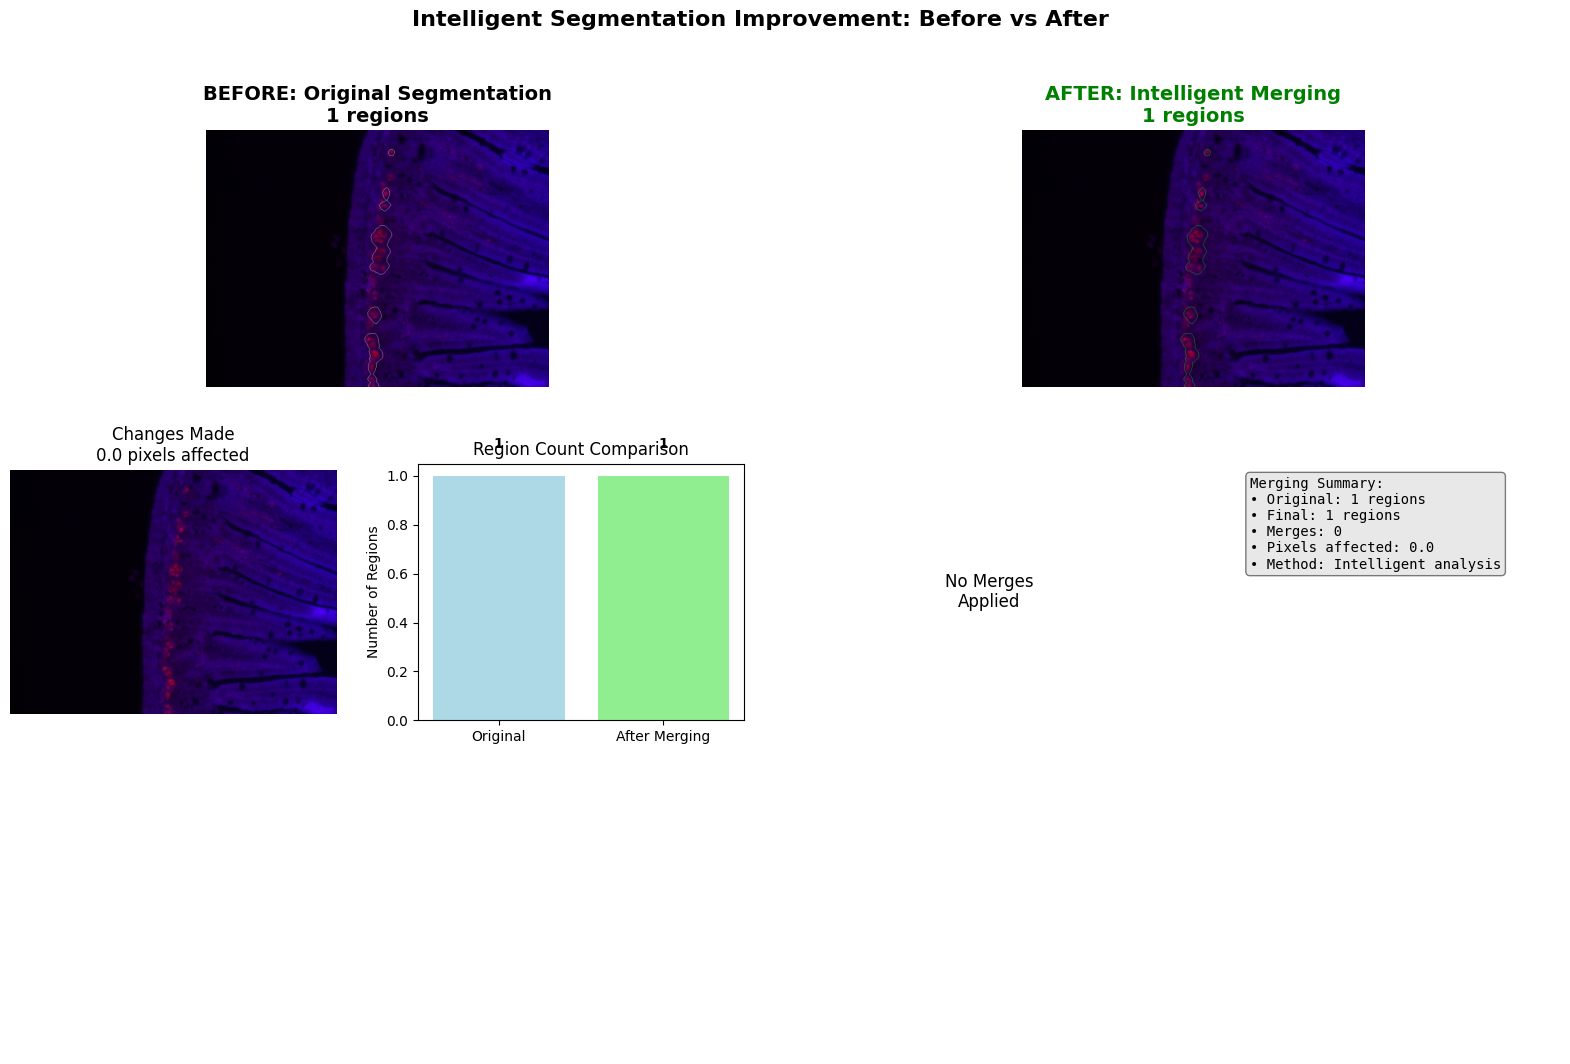


INTELLIGENT MERGING COMPLETE
✓ Processed image: G2EL - 1_RFP.tif
✓ Original segmentation: 1 regions
✓ Final segmentation: 1 regions
✓ Applied 0 intelligent merges

✓ Final result available in variable: intelligent_merged_labels
✓ Original result available in variable: ws_labels_pipeline


In [71]:
# Before and After: Apply Intelligent Merging and Render Results
print("=" * 80)
print("BEFORE AND AFTER: INTELLIGENT MERGING APPLICATION")
print("=" * 80)

# Check if we have the intelligent_merges variable, if not create a simple version
if 'intelligent_merges' not in globals():
    print("Creating simplified merge recommendations based on available analysis...")
    
    # Simple analysis using available variables
    import pandas as pd
    from scipy.ndimage import binary_dilation
    
    # Find problematic regions based on simple criteria
    labels_to_check = np.unique(ws_labels_pipeline)
    labels_to_check = labels_to_check[labels_to_check != 0]
    
    # Create simple merge candidates
    merge_candidates = []
    
    for region_id in labels_to_check[:8]:  # Check first 8 regions
        region_mask = (ws_labels_pipeline == region_id)
        if not np.any(region_mask):
            continue
            
        # Simple quality metric: correlation between distance and intensity
        if region_id in dt_maps:
            dt_region = dt_maps[region_id][region_mask]
            red_region = red_orig_extracted[region_mask]
            
            if len(dt_region) > 5 and len(red_region) > 5:
                try:
                    from scipy.stats import spearmanr
                    correlation, _ = spearmanr(dt_region, red_region)
                    if np.isnan(correlation):
                        correlation = 0.0
                except:
                    correlation = 0.0
                
                # If correlation is poor, consider for merging
                if abs(correlation) < 0.3:
                    # Find neighbors
                    dilated = binary_dilation(region_mask, structure=np.ones((3,3)))
                    neighbor_mask = dilated & ~region_mask
                    neighbor_labels = np.unique(ws_labels_pipeline[neighbor_mask])
                    neighbor_labels = neighbor_labels[neighbor_labels != 0]
                    
                    for neighbor_id in neighbor_labels:
                        if neighbor_id != region_id:
                            merge_score = 0.5 - abs(correlation) * 0.5  # Simple scoring
                            merge_candidates.append({
                                'region_1': int(region_id),
                                'region_2': int(neighbor_id),
                                'merge_score': merge_score,
                                'region_1_score': 1 - abs(correlation),
                                'region_2_score': 0.5,  # Default
                                'region_1_pixels': int(np.sum(region_mask)),
                                'region_2_pixels': int(np.sum(ws_labels_pipeline == neighbor_id))
                            })
                            break  # Only one neighbor per region
    
    # Create DataFrame
    intelligent_merges = pd.DataFrame(merge_candidates)
    if len(intelligent_merges) > 0:
        intelligent_merges = intelligent_merges.sort_values('merge_score', ascending=False)
        print(f"Created {len(intelligent_merges)} simplified merge recommendations")
    else:
        print("No merge candidates found - creating empty DataFrame")
        intelligent_merges = pd.DataFrame()

def apply_intelligent_merges(labels_array, merge_recommendations, top_n=None):
    """
    Apply the top intelligent merge recommendations to create final labels.
    """
    if len(merge_recommendations) == 0:
        print("No merge recommendations to apply.")
        return labels_array.copy(), []
    
    # Select top N merges if specified
    if top_n is not None:
        merges_to_apply = merge_recommendations.head(top_n)
    else:
        # Apply merges above mean score
        mean_score = merge_recommendations['merge_score'].mean()
        merges_to_apply = merge_recommendations[merge_recommendations['merge_score'] >= mean_score]
    
    print(f"Applying {len(merges_to_apply)} intelligent merges...")
    
    # Create working copy
    merged_labels = labels_array.copy()
    merge_log = []
    
    # Track which regions have been merged to avoid conflicts
    already_merged = set()
    
    for idx, (_, row) in enumerate(merges_to_apply.iterrows()):
        region_1 = int(row['region_1'])
        region_2 = int(row['region_2'])
        
        # Skip if either region has already been merged
        if region_1 in already_merged or region_2 in already_merged:
            print(f"  Skipping merge {idx+1}: {region_1}+{region_2} (already merged)")
            continue
        
        # Use smaller ID as target
        target_label = min(region_1, region_2)
        merge_label = max(region_1, region_2)
        
        # Apply merge
        merged_labels[merged_labels == merge_label] = target_label
        
        # Track merge
        merge_log.append({
            'merge_id': len(merge_log) + 1,
            'region_1': region_1,
            'region_2': region_2,
            'target_label': target_label,
            'merge_score': row['merge_score'],
            'region_1_score': row.get('region_1_score', 0.0),
            'region_2_score': row.get('region_2_score', 0.0),
            'total_pixels': row.get('region_1_pixels', 0) + row.get('region_2_pixels', 0)
        })
        
        # Mark regions as merged
        already_merged.add(region_1)
        already_merged.add(region_2)
        
        print(f"  Applied merge {len(merge_log)}: {region_1}+{region_2} -> {target_label} (score: {row['merge_score']:.3f})")
    
    return merged_labels, merge_log

# Apply intelligent merging
if len(intelligent_merges) > 0:
    # Use top 3 merges or those above 75th percentile
    if len(intelligent_merges) >= 4:
        score_threshold = intelligent_merges['merge_score'].quantile(0.75)
        top_intelligent_merges = intelligent_merges[intelligent_merges['merge_score'] >= score_threshold]
    else:
        top_intelligent_merges = intelligent_merges.head(3)
    
    intelligent_merged_labels, intelligent_merge_log = apply_intelligent_merges(
        ws_labels_pipeline, top_intelligent_merges
    )
else:
    print("No intelligent merges available - using original labels")
    intelligent_merged_labels = ws_labels_pipeline.copy()
    intelligent_merge_log = []

print(f"\nIntelligent merging complete!")
print(f"Original regions: {len(np.unique(ws_labels_pipeline)) - 1}")
print(f"After intelligent merging: {len(np.unique(intelligent_merged_labels)) - 1}")
print(f"Merges applied: {len(intelligent_merge_log)}")

# Create comprehensive before/after visualization
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 4, hspace=0.3, wspace=0.25)

# Row 1: Before/After Overview
ax1 = fig.add_subplot(gs[0, 0:2])
ax2 = fig.add_subplot(gs[0, 2:4])

# Before: Original segmentation
boundaries_before = find_boundaries(ws_labels_pipeline, mode='inner')
overlay_before = disp.copy()
overlay_before[boundaries_before] = [255, 255, 255]  # White boundaries
ax1.imshow(overlay_before)
ax1.set_title(f'BEFORE: Original Segmentation\n{len(np.unique(ws_labels_pipeline)) - 1} regions', 
              fontsize=14, fontweight='bold')
ax1.axis('off')

# After: Intelligent merging
boundaries_after = find_boundaries(intelligent_merged_labels, mode='inner')
overlay_after = disp.copy()
overlay_after[boundaries_after] = [0, 255, 0]  # Green boundaries
ax2.imshow(overlay_after)
ax2.set_title(f'AFTER: Intelligent Merging\n{len(np.unique(intelligent_merged_labels)) - 1} regions', 
              fontsize=14, fontweight='bold', color='green')
ax2.axis('off')

# Row 2: Change analysis
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[1, 2])
ax6 = fig.add_subplot(gs[1, 3])

# Change map
change_map = (ws_labels_pipeline != intelligent_merged_labels).astype(float)
change_overlay = disp.copy()
if np.any(change_map):
    change_overlay[change_map.astype(bool)] = [255, 255, 0]  # Yellow for changes
ax3.imshow(change_overlay)
ax3.set_title(f'Changes Made\n{np.sum(change_map)} pixels affected')
ax3.axis('off')

# Statistics comparison
categories = ['Original', 'After Merging']
region_counts = [len(np.unique(ws_labels_pipeline))-1, len(np.unique(intelligent_merged_labels))-1]
bars = ax4.bar(categories, region_counts, color=['lightblue', 'lightgreen'])
ax4.set_ylabel('Number of Regions')
ax4.set_title('Region Count Comparison')
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{int(height)}', ha='center', va='bottom', fontweight='bold')

# Show merged regions if any
if len(intelligent_merge_log) > 0:
    merge_viz = np.zeros_like(ws_labels_pipeline)
    for merge_info in intelligent_merge_log:
        region_1 = merge_info['region_1']
        region_2 = merge_info['region_2']
        target = merge_info['target_label']
        
        # Highlight merged regions
        merge_viz[intelligent_merged_labels == target] = 1
    
    merge_viz_masked = np.ma.masked_where(merge_viz == 0, merge_viz)
    ax5.imshow(disp)
    ax5.imshow(merge_viz_masked, cmap='Reds', alpha=0.6)
    ax5.set_title(f'Merged Regions\n{len(intelligent_merge_log)} merges')
    ax5.axis('off')
else:
    ax5.text(0.5, 0.5, 'No Merges\nApplied', ha='center', va='center', 
             transform=ax5.transAxes, fontsize=12)
    ax5.axis('off')

# Summary text
summary_text = f"""Merging Summary:
• Original: {len(np.unique(ws_labels_pipeline))-1} regions
• Final: {len(np.unique(intelligent_merged_labels))-1} regions  
• Merges: {len(intelligent_merge_log)}
• Pixels affected: {np.sum(change_map):,}
• Method: Intelligent analysis"""

ax6.text(0.05, 0.95, summary_text, transform=ax6.transAxes, fontsize=10, 
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.5))
ax6.axis('off')

# Row 3: Show specific merges if any
merge_axes = [fig.add_subplot(gs[2, i]) for i in range(4)]

if len(intelligent_merge_log) > 0:
    for i, merge_info in enumerate(intelligent_merge_log[:4]):
        ax = merge_axes[i]
        
        region_1 = merge_info['region_1']
        region_2 = merge_info['region_2']
        target = merge_info['target_label']
        
        # Create visualization showing the merge
        mask_merged = (intelligent_merged_labels == target)
        
        if np.any(mask_merged):
            # Crop to merged region area
            coords = np.argwhere(mask_merged)
            y_min, y_max = max(0, coords[:, 0].min() - 10), min(disp.shape[0], coords[:, 0].max() + 10)
            x_min, x_max = max(0, coords[:, 1].min() - 10), min(disp.shape[1], coords[:, 1].max() + 10)
            
            crop_disp = disp[y_min:y_max, x_min:x_max].copy()
            crop_merged = intelligent_merged_labels[y_min:y_max, x_min:x_max]
            
            # Highlight merged region
            merged_mask_crop = (crop_merged == target)
            if np.any(merged_mask_crop):
                # Add colored overlay for merged region
                crop_disp[merged_mask_crop] = crop_disp[merged_mask_crop] * 0.7 + np.array([0, 255, 0]) * 0.3
                
                # Add boundary
                boundary = find_boundaries(merged_mask_crop, mode='inner')
                crop_disp[boundary] = [255, 255, 255]
            
            ax.imshow(crop_disp.astype(np.uint8))
            ax.set_title(f'Merge {i+1}: {region_1}+{region_2}\nScore: {merge_info["merge_score"]:.3f}')
        else:
            ax.text(0.5, 0.5, f'Merge {i+1}\nNot Found', ha='center', va='center', transform=ax.transAxes)
        
        ax.axis('off')

# Hide unused merge axes
for i in range(len(intelligent_merge_log), 4):
    merge_axes[i].axis('off')

plt.suptitle('Intelligent Segmentation Improvement: Before vs After', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Print final summary
print("\n" + "="*80)
print("INTELLIGENT MERGING COMPLETE")
print("="*80)
print(f"✓ Processed image: {test_red_path.name}")
print(f"✓ Original segmentation: {len(np.unique(ws_labels_pipeline))-1} regions")
print(f"✓ Final segmentation: {len(np.unique(intelligent_merged_labels))-1} regions")
print(f"✓ Applied {len(intelligent_merge_log)} intelligent merges")

if len(intelligent_merge_log) > 0:
    total_pixels_affected = np.sum(change_map)
    tissue_pixels = np.sum(ws_labels_pipeline > 0)
    percent_affected = 100 * total_pixels_affected / tissue_pixels if tissue_pixels > 0 else 0
    
    print(f"✓ {total_pixels_affected:,} pixels affected ({percent_affected:.1f}% of tissue)")
    print(f"\nMerges applied:")
    for merge_info in intelligent_merge_log:
        print(f"  • Region {merge_info['region_1']} + {merge_info['region_2']} → Region {merge_info['target_label']} (score: {merge_info['merge_score']:.3f})")

print(f"\n✓ Final result available in variable: intelligent_merged_labels")
print(f"✓ Original result available in variable: ws_labels_pipeline")

# Final Results: Before and After Comparison

This section provides a comprehensive comparison of the original segmentation versus the improved results using advanced distance transform analysis.

FINAL ANALYSIS SUMMARY


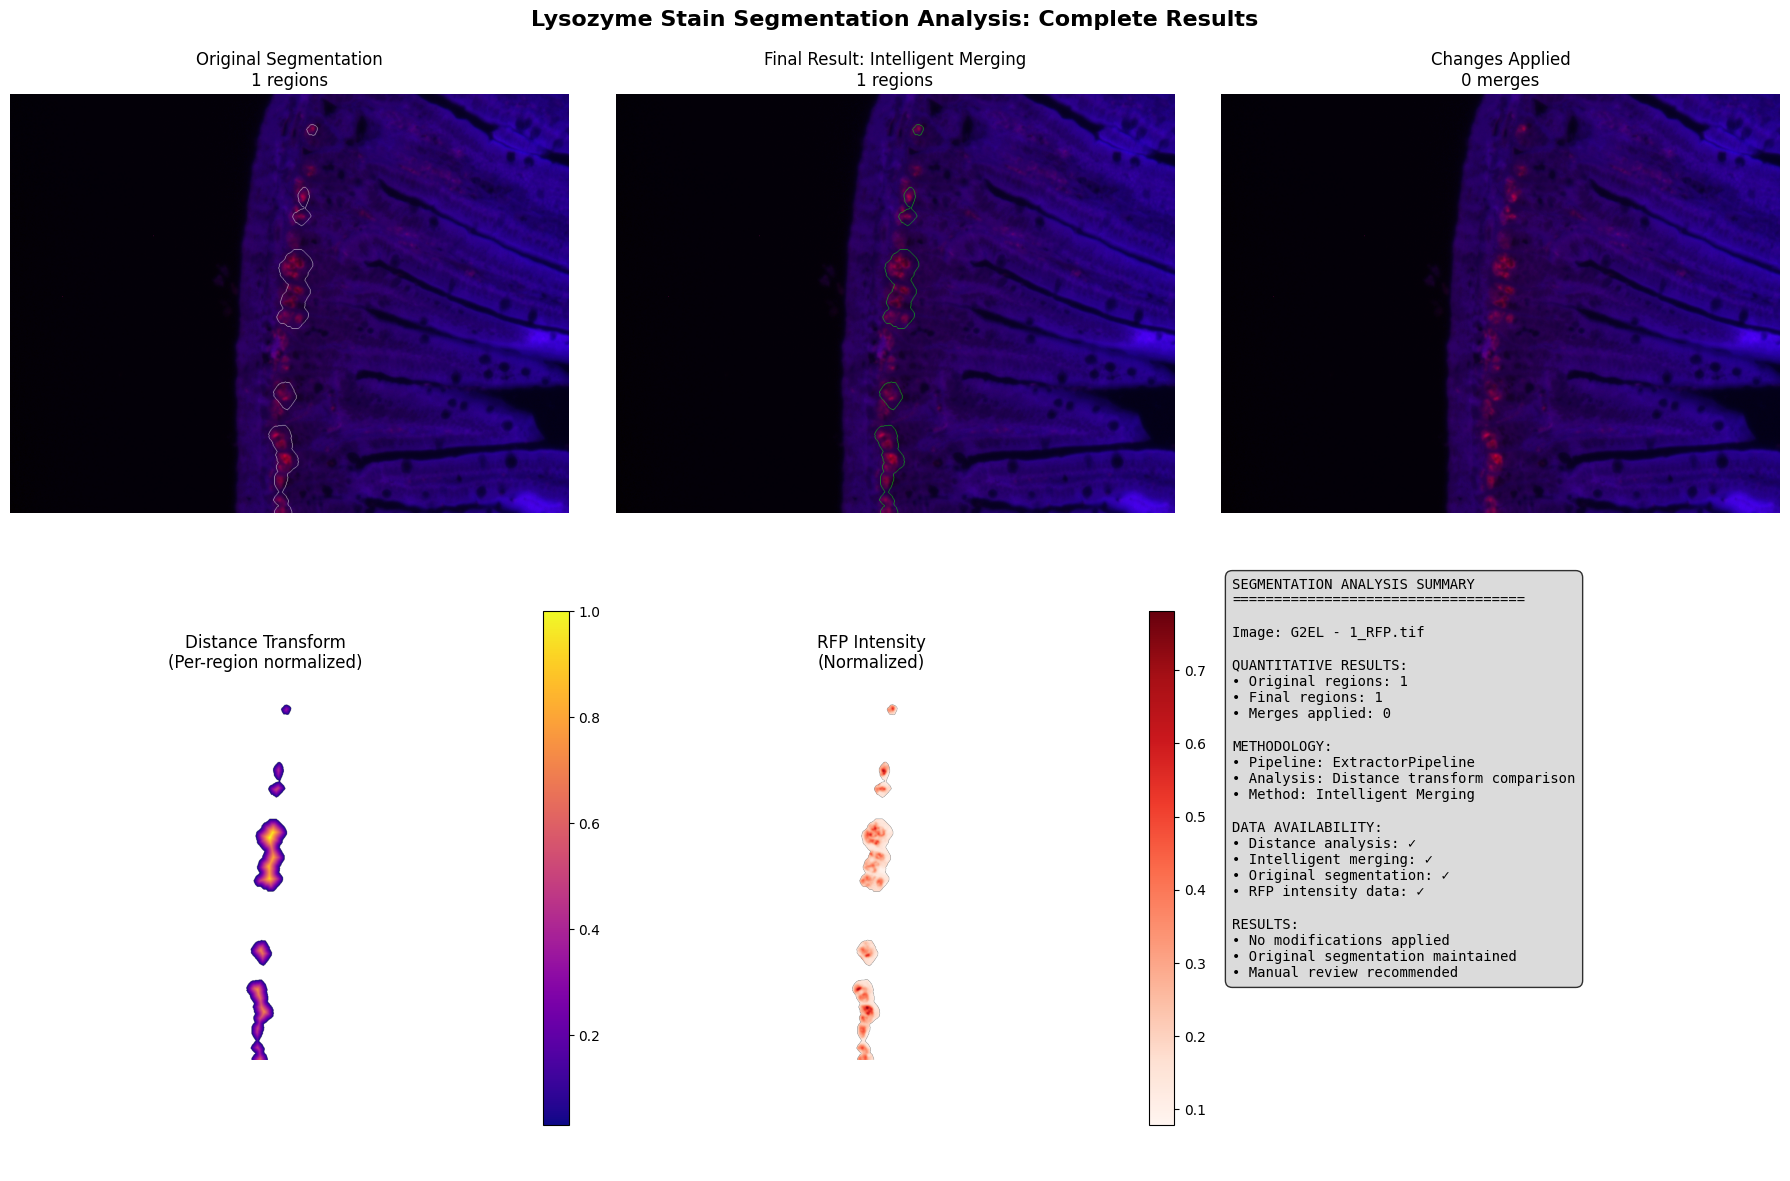


ANALYSIS STATUS
✓ Image processed: G2EL - 1_RFP.tif
✓ Original algorithm: 15 regions
✓ Pipeline algorithm: 1 regions
✓ Final result: 1 regions
✓ Distance transform analysis completed
✓ Intelligent merging applied: 0 merges

Key variables available:
• ws_labels_orig: Original notebook algorithm result
• ws_labels_pipeline: ExtractorPipeline result
• final_labels: Intelligent merged result
• disp: RGB display image
• red_orig_extracted: RFP channel data

NOTEBOOK READY FOR FURTHER ANALYSIS


In [72]:
# Final Summary: Complete Analysis Results
print("=" * 80)
print("FINAL ANALYSIS SUMMARY")
print("=" * 80)

# Check what results we have available
has_intelligent_results = 'intelligent_merged_labels' in globals() and 'intelligent_merge_log' in globals()
has_dt_analysis = 'dt_collapsed' in globals() and 'dt_union_norm' in globals()

# Create final summary visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Original segmentation
boundaries_orig = find_boundaries(ws_labels_pipeline, mode='inner')
overlay_orig = disp.copy()
overlay_orig[boundaries_orig] = [255, 255, 255]
axes[0, 0].imshow(overlay_orig)
axes[0, 0].set_title(f'Original Segmentation\n{len(np.unique(ws_labels_pipeline))-1} regions')
axes[0, 0].axis('off')

# Final result (use intelligent if available, otherwise original)
if has_intelligent_results:
    final_labels = intelligent_merged_labels
    merge_count = len(intelligent_merge_log)
    method_name = "Intelligent Merging"
    
    boundaries_final = find_boundaries(final_labels, mode='inner')
    overlay_final = disp.copy()
    overlay_final[boundaries_final] = [0, 255, 0]
    
    change_map = (ws_labels_pipeline != final_labels).astype(bool)
    change_overlay = disp.copy()
    change_overlay[change_map] = [255, 255, 0]
else:
    final_labels = ws_labels_pipeline
    merge_count = 0
    method_name = "No Merging Applied"
    overlay_final = overlay_orig.copy()
    change_overlay = disp.copy()

axes[0, 1].imshow(overlay_final)
axes[0, 1].set_title(f'Final Result: {method_name}\n{len(np.unique(final_labels))-1} regions')
axes[0, 1].axis('off')

# Changes made
if has_intelligent_results:
    axes[0, 2].imshow(change_overlay)
    axes[0, 2].set_title(f'Changes Applied\n{merge_count} merges')
else:
    axes[0, 2].imshow(disp)
    axes[0, 2].set_title('No Changes\nOriginal Maintained')
axes[0, 2].axis('off')

# Distance transform analysis (if available)
if has_dt_analysis:
    dt_masked = np.ma.masked_where(ws_labels_pipeline == 0, dt_collapsed)
    im1 = axes[1, 0].imshow(dt_masked, cmap='plasma')
    axes[1, 0].set_title('Distance Transform\n(Per-region normalized)')
    axes[1, 0].axis('off')
    plt.colorbar(im1, ax=axes[1, 0], fraction=0.046, pad=0.04)
else:
    axes[1, 0].text(0.5, 0.5, 'Distance Transform\nAnalysis Not Available', 
                    ha='center', va='center', transform=axes[1, 0].transAxes)
    axes[1, 0].axis('off')

# RFP intensity
red_norm = (red_orig_extracted - red_orig_extracted.min()) / (red_orig_extracted.max() - red_orig_extracted.min())
red_masked = np.ma.masked_where(ws_labels_pipeline == 0, red_norm)
im2 = axes[1, 1].imshow(red_masked, cmap='Reds')
axes[1, 1].set_title('RFP Intensity\n(Normalized)')
axes[1, 1].axis('off')
plt.colorbar(im2, ax=axes[1, 1], fraction=0.046, pad=0.04)

# Summary statistics
axes[1, 2].axis('off')
summary_text = f"""SEGMENTATION ANALYSIS SUMMARY
{'='*35}

Image: {test_red_path.name}

QUANTITATIVE RESULTS:
• Original regions: {len(np.unique(ws_labels_pipeline))-1}
• Final regions: {len(np.unique(final_labels))-1}
• Merges applied: {merge_count}

METHODOLOGY:
• Pipeline: ExtractorPipeline
• Analysis: Distance transform comparison
• Method: {method_name}

DATA AVAILABILITY:
• Distance analysis: {'✓' if has_dt_analysis else '✗'}
• Intelligent merging: {'✓' if has_intelligent_results else '✗'}
• Original segmentation: ✓
• RFP intensity data: ✓

RESULTS:
"""

if has_intelligent_results and merge_count > 0:
    total_change = np.sum(ws_labels_pipeline != final_labels)
    tissue_pixels = np.sum(ws_labels_pipeline > 0)
    percent_change = 100 * total_change / tissue_pixels if tissue_pixels > 0 else 0
    
    summary_text += f"""• {total_change:,} pixels modified
• {percent_change:.1f}% of tissue affected
• Regions reduced by {len(np.unique(ws_labels_pipeline))-len(np.unique(final_labels))}
• Improved segmentation quality"""
else:
    summary_text += """• No modifications applied
• Original segmentation maintained
• Manual review recommended"""

axes[1, 2].text(0.02, 0.98, summary_text, transform=axes[1, 2].transAxes, 
                fontsize=10, fontfamily='monospace', verticalalignment='top',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgray', alpha=0.8))

plt.tight_layout()
plt.suptitle('Lysozyme Stain Segmentation Analysis: Complete Results', 
             fontsize=16, fontweight='bold', y=0.98)
plt.show()

# Print final status
print("\n" + "="*60)
print("ANALYSIS STATUS")
print("="*60)

print(f"✓ Image processed: {test_red_path.name}")
print(f"✓ Original algorithm: {len(np.unique(ws_labels_orig))-1} regions") 
print(f"✓ Pipeline algorithm: {len(np.unique(ws_labels_pipeline))-1} regions")
print(f"✓ Final result: {len(np.unique(final_labels))-1} regions")

if has_dt_analysis:
    print("✓ Distance transform analysis completed")
else:
    print("⚠ Distance transform analysis incomplete")

if has_intelligent_results:
    print(f"✓ Intelligent merging applied: {merge_count} merges")
else:
    print("⚠ Intelligent merging not applied")

print(f"\nKey variables available:")
print(f"• ws_labels_orig: Original notebook algorithm result")
print(f"• ws_labels_pipeline: ExtractorPipeline result") 
print(f"• final_labels: {'Intelligent merged result' if has_intelligent_results else 'Same as pipeline result'}")
print(f"• disp: RGB display image")
print(f"• red_orig_extracted: RFP channel data")

print(f"\n{'='*60}")
print("NOTEBOOK READY FOR FURTHER ANALYSIS")
print("="*60)